In [1]:
from LstmVAE import LSTM_Var_Autoencoder
import pandas as pd
import numpy as np

c:\USERS\JEDRE\MINICONDA3\ENVS\LSTMVAE\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\USERS\JEDRE\MINICONDA3\ENVS\LSTMVAE\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\USERS\JEDRE\MINICONDA3\ENVS\LSTMVAE\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\USERS\JEDRE\MINICONDA3\ENVS\LSTMVAE\lib\site-packages\tensorf

In [2]:
n_rows = 500
n_classes = 4
# Prepare sample data
timestamp = pd.date_range(start='2020-01-01', periods=n_rows, freq='D')
time_series = pd.DataFrame({'values': np.random.randn(n_rows)}, index=timestamp)
# y = get_random_probs(n_rows, n_classes)
# labels = pd.DataFrame({'label': np.random.randint(0, n_classes, size=n_rows)}, index=timestamp)
ext_features = pd.DataFrame({
    'feature1': np.random.randn(n_rows),
    'feature2': np.random.randn(n_rows)
}, index=timestamp)

combined_data = ext_features


combined_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2020-01-01 to 2021-05-14
Freq: D
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  500 non-null    float64
 1   feature2  500 non-null    float64
dtypes: float64(2)
memory usage: 11.7 KB


In [3]:
from LstmVAE import preprocess

df = preprocess(combined_data)

Data normalized


In [4]:
vae = LSTM_Var_Autoencoder(intermediate_dim = 15,z_dim = 3, n_dim=2, stateful = True) #default stateful = False

Instructions for updating:
Use the retry module or similar alternatives.


In [5]:
import tensorflow as tf

In [6]:
df.shape

(500, 2)

In [7]:
timesteps = 10
df_reshaped = df.reshape(-1,timesteps,2)

In [8]:
df_reshaped.shape

(50, 10, 2)

In [9]:
vae.fit(df_reshaped, learning_rate=0.001, batch_size = 100, num_epochs = 200, opt = tf.train.AdamOptimizer, REG_LAMBDA = 0.01,
            grad_clip_norm=10, optimizer_params=None, verbose = True)



Training...


Epoch   1    Loss 0.17225
Epoch   11   Loss 0.15821
Epoch   21   Loss 0.15138
Epoch   31   Loss 0.14746
Epoch   41   Loss 0.14247
Epoch   51   Loss 0.13873
Epoch   61   Loss 0.13404
Epoch   71   Loss 0.12887
Epoch   81   Loss 0.12196
Epoch   91   Loss 0.11399
Epoch  101   Loss 0.10880
Epoch  111   Loss 0.10778
Epoch  121   Loss 0.10734
Epoch  131   Loss 0.10667
Epoch  141   Loss 0.10723
Epoch  151   Loss 0.10692
Epoch  161   Loss 0.10665
Epoch  171   Loss 0.10710
Epoch  181   Loss 0.10724
Epoch  191   Loss 0.10659


Training time 0.09 minutes


In [10]:
x_reconstructed, recons_error = vae.reconstruct(df_reshaped, get_error = True) #returns squared error

In [11]:
x_reduced = vae.reduce(df_reshaped) #latent space representation

In [12]:
recons_error.shape

(50, 10, 2)

In [13]:
recons_error.reshape(df.shape).shape

(500, 2)

In [14]:
reconstruction_err = recons_error.reshape(df.shape) # reshape error array back to original dim
reconstruction_err = reconstruction_err.sum(axis=1) # sum reconstruction error for each feature

In [15]:
import matplotlib.pyplot as plt

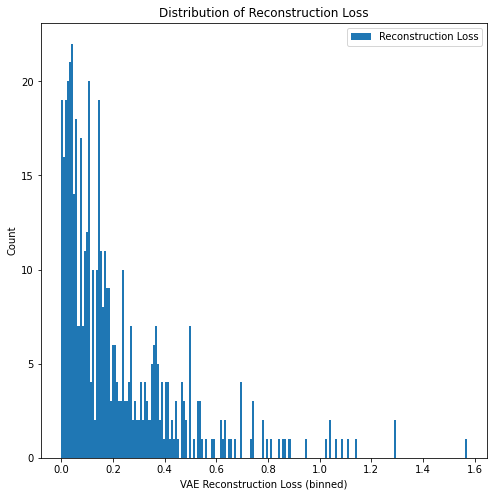

In [17]:
plt.figure(figsize=(8, 8))
plt.hist([reconstruction_err], bins=200, stacked=True, label=['Reconstruction Loss'])
plt.title("Distribution of Reconstruction Loss")
plt.xlabel("VAE Reconstruction Loss (binned)")
plt.ylabel("Count")
plt.legend();

In [19]:
data_wth_loss = combined_data.copy()
data_wth_loss['loss'] = reconstruction_err

In [23]:
quant = 0.99
thresh = data_wth_loss['loss'].quantile(quant)
print(f'Threshold ({quant} quantile) : {thresh}')


Threshold (0.99 quantile) : 1.0878867399692533


In [25]:
data_wth_loss['anomaly'] = data_wth_loss['loss'] > thresh
data_wth_loss.head()

,feature1,feature2,loss,anomaly
2020-01-01,-0.782540,0.495644,0.095507,False
2020-01-02,1.031076,0.843880,0.214238,False
2020-01-03,-1.666813,-0.065168,0.311633,False
2020-01-04,0.698485,-1.131269,0.171706,False
2020-01-05,0.504629,0.916312,0.118333,False


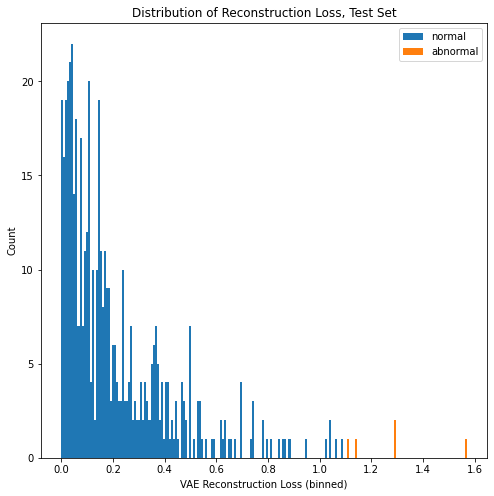

In [26]:
plt.figure(figsize=(8, 8))
anomalies_loss = data_wth_loss.loc[data_wth_loss['anomaly'], 'loss']
normals_loss   = data_wth_loss.loc[~data_wth_loss['anomaly'], 'loss']
plt.hist([normals_loss, anomalies_loss], bins=200, stacked=True, label=['normal', 'abnormal'])
plt.title("Distribution of Reconstruction Loss, Test Set")
plt.xlabel("VAE Reconstruction Loss (binned)")
plt.ylabel("Count")
plt.legend();

In [31]:
anomalies_ts.values

array([-2.49784748, -3.1872368 , -1.83662067, -1.24898799,  2.56660481])

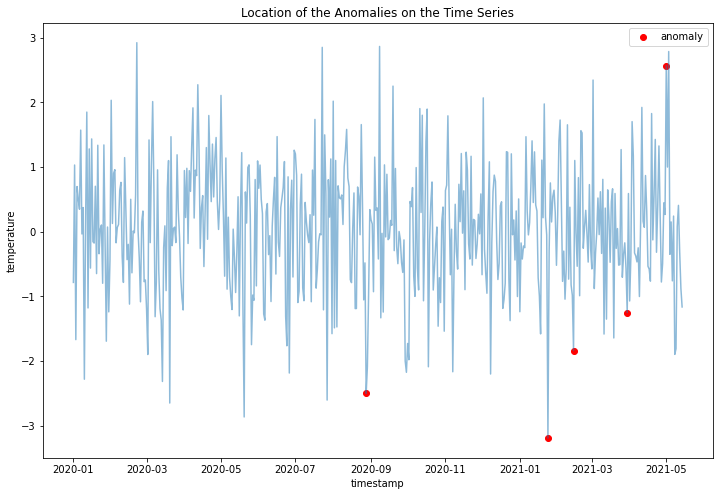

In [33]:
anomalies_ts = data_wth_loss.loc[data_wth_loss['anomaly'], ('feature1')]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data_wth_loss.index, data_wth_loss['feature1'], alpha=.5)
ax.scatter(anomalies_ts.index, anomalies_ts.values, color='red', label='anomaly')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series");

### Hypertuning with Optuna

In [35]:
import optuna
from optuna.trial import TrialState

# Define the objective function for Optuna
def objective(trial):

    # Suggest values for the hyperparameters
    intermediate_dim = trial.suggest_int('intermediate_dim', 16, 128)
    z_dim = trial.suggest_int('z_dim', 2, 20)
    kulback_coef = trial.suggest_float('kulback_coef', 0.01, 0.5, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 256, log=True)
    num_epochs = trial.suggest_int('num_epochs', 50, 500)
    
    # Create the model instance with the suggested parameters
    vae_model = LSTM_Var_Autoencoder(
        intermediate_dim=intermediate_dim, 
        z_dim=z_dim, 
        n_dim=2, 
        kulback_coef=kulback_coef
    )
    
    # Train the model using the suggested parameters
    vae_model.fit(
        df_reshaped, 
        learning_rate=learning_rate, 
        batch_size=batch_size, 
        num_epochs=num_epochs
    )
    
    # Evaluate the model on the validation set
    x_reconstructed, squared_error = vae_model.reconstruct(df_reshaped, get_error=True)
    
    # Return the mean squared error as the objective value
    return np.mean(squared_error)

# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization process
study.optimize(objective, n_trials=100)

# Print the best parameters
print("Best hyperparameters: ", study.best_params)


c:\USERS\JEDRE\MINICONDA3\ENVS\LSTMVAE\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-24 13:17:48,904] A new study created in memory with name: no-name-2b5e342f-6e00-4e22-8461-df91435bd9d3




Training...


Epoch   1    Loss 0.16371
Epoch   11   Loss 0.16191
Epoch   21   Loss 0.16378
Epoch   31   Loss 0.16564
Epoch   41   Loss 0.15092
Epoch   51   Loss 0.15250
Epoch   61   Loss 0.15742
Epoch   71   Loss 0.15717
Epoch   81   Loss 0.15443
Epoch   91   Loss 0.15699
Epoch  101   Loss 0.15054
Epoch  111   Loss 0.14530
Epoch  121   Loss 0.14797
Epoch  131   Loss 0.15380
Epoch  141   Loss 0.15286
Epoch  151   Loss 0.15503


[I 2024-10-24 13:17:54,100] Trial 0 finished with value: 0.1356959193944931 and parameters: {'intermediate_dim': 32, 'z_dim': 5, 'kulback_coef': 0.016494035842631045, 'learning_rate': 1.7481192808894794e-05, 'batch_size': 151, 'num_epochs': 162}. Best is trial 0 with value: 0.1356959193944931.


Epoch  161   Loss 0.15479


Training time 0.06 minutes


Training...


Epoch   1    Loss 0.22076
Epoch   11   Loss 0.20801
Epoch   21   Loss 0.19684
Epoch   31   Loss 0.18493
Epoch   41   Loss 0.14935
Epoch   51   Loss 0.11119
Epoch   61   Loss 0.11115
Epoch   71   Loss 0.10974
Epoch   81   Loss 0.10890
Epoch   91   Loss 0.10726
Epoch  101   Loss 0.10713
Epoch  111   Loss 0.10904
Epoch  121   Loss 0.10838


Training time 0.07 minutes


[I 2024-10-24 13:17:59,530] Trial 1 finished with value: 0.10839559882879257 and parameters: {'intermediate_dim': 110, 'z_dim': 20, 'kulback_coef': 0.0306557278925761, 'learning_rate': 0.0005087304757264247, 'batch_size': 62, 'num_epochs': 128}. Best is trial 1 with value: 0.10839559882879257.




Training...


Epoch   1    Loss 0.18282
Epoch   11   Loss 0.15366
Epoch   21   Loss 0.14083
Epoch   31   Loss 0.11922
Epoch   41   Loss 0.11122
Epoch   51   Loss 0.10781
Epoch   61   Loss 0.10670
Epoch   71   Loss 0.10744
Epoch   81   Loss 0.10790
Epoch   91   Loss 0.10714
Epoch  101   Loss 0.10666
Epoch  111   Loss 0.10613
Epoch  121   Loss 0.10693
Epoch  131   Loss 0.10843
Epoch  141   Loss 0.10688
Epoch  151   Loss 0.10656
Epoch  161   Loss 0.10580
Epoch  171   Loss 0.10676
Epoch  181   Loss 0.10780
Epoch  191   Loss 0.10675
Epoch  201   Loss 0.10610
Epoch  211   Loss 0.10553
Epoch  221   Loss 0.10724
Epoch  231   Loss 0.10798
Epoch  241   Loss 0.10673
Epoch  251   Loss 0.10589
Epoch  261   Loss 0.10555
Epoch  271   Loss 0.10703
Epoch  281   Loss 0.10788
Epoch  291   Loss 0.10697
Epoch  301   Loss 0.10615
Epoch  311   Loss 0.10595
Epoch  321   Loss 0.10710
Epoch  331   Loss 0.10788
Epoch  341   Loss 0.10682
Epoch  351   Loss 0.10580
Epoch  361   Loss 0.10571
Epoch  371   Loss 0.10

[I 2024-10-24 13:18:09,315] Trial 2 finished with value: 0.1064893901348114 and parameters: {'intermediate_dim': 34, 'z_dim': 15, 'kulback_coef': 0.020738141273535335, 'learning_rate': 0.002137337017171107, 'batch_size': 93, 'num_epochs': 485}. Best is trial 2 with value: 0.1064893901348114.


Epoch  481   Loss 0.10768


Training time 0.14 minutes


Training...


Epoch   1    Loss 0.13241
Epoch   11   Loss 0.12662
Epoch   21   Loss 0.12327
Epoch   31   Loss 0.12377
Epoch   41   Loss 0.12521
Epoch   51   Loss 0.12724
Epoch   61   Loss 0.12589
Epoch   71   Loss 0.12538
Epoch   81   Loss 0.11933
Epoch   91   Loss 0.12699
Epoch  101   Loss 0.12062
Epoch  111   Loss 0.12839
Epoch  121   Loss 0.12289
Epoch  131   Loss 0.11954
Epoch  141   Loss 0.12474
Epoch  151   Loss 0.12217
Epoch  161   Loss 0.11948
Epoch  171   Loss 0.11593
Epoch  181   Loss 0.11849
Epoch  191   Loss 0.11860
Epoch  201   Loss 0.11792
Epoch  211   Loss 0.11888
Epoch  221   Loss 0.11763
Epoch  231   Loss 0.11624
Epoch  241   Loss 0.11918
Epoch  251   Loss 0.11625
Epoch  261   Loss 0.11792
Epoch  271   Loss 0.11777
Epoch  281   Loss 0.11781
Epoch  291   Loss 0.11668
Epoch  301   Loss 0.11646
Epoch  311   Loss 0.11834
Epoch  321   Loss 0.11511
Epoch  331   Loss 0.11319
Epoch  341   Loss 0.11608
Epoch  351   Loss 0

[I 2024-10-24 13:18:24,259] Trial 3 finished with value: 0.10771026462316513 and parameters: {'intermediate_dim': 24, 'z_dim': 3, 'kulback_coef': 0.012108359719973115, 'learning_rate': 1.9596827878112926e-05, 'batch_size': 33, 'num_epochs': 490}. Best is trial 2 with value: 0.1064893901348114.




Training time 0.23 minutes


Training...


Epoch   1    Loss 0.31411
Epoch   11   Loss 0.29882
Epoch   21   Loss 0.28916
Epoch   31   Loss 0.28138
Epoch   41   Loss 0.26405
Epoch   51   Loss 0.24937
Epoch   61   Loss 0.22143
Epoch   71   Loss 0.17058
Epoch   81   Loss 0.11699
Epoch   91   Loss 0.11171
Epoch  101   Loss 0.11171
Epoch  111   Loss 0.11037
Epoch  121   Loss 0.10990
Epoch  131   Loss 0.10737
Epoch  141   Loss 0.10927
Epoch  151   Loss 0.10826
Epoch  161   Loss 0.10950
Epoch  171   Loss 0.10812
Epoch  181   Loss 0.10772
Epoch  191   Loss 0.10818
Epoch  201   Loss 0.10797
Epoch  211   Loss 0.10750
Epoch  221   Loss 0.10865
Epoch  231   Loss 0.10667
Epoch  241   Loss 0.10945
Epoch  251   Loss 0.10844
Epoch  261   Loss 0.10900
Epoch  271   Loss 0.10650
Epoch  281   Loss 0.10693
Epoch  291   Loss 0.10627
Epoch  301   Loss 0.10683
Epoch  311   Loss 0.10894
Epoch  321   Loss 0.10739
Epoch  331   Loss 0.10642
Epoch  341   Loss 0.10702
Epoch  351   Loss 0.10767
Epoch  361   Loss 0

[I 2024-10-24 13:18:37,467] Trial 4 finished with value: 0.10753379762172699 and parameters: {'intermediate_dim': 52, 'z_dim': 13, 'kulback_coef': 0.08162864127442587, 'learning_rate': 0.0001816398669850722, 'batch_size': 33, 'num_epochs': 403}. Best is trial 2 with value: 0.1064893901348114.


Epoch  401   Loss 0.10742


Training time 0.20 minutes


Training...


Epoch   1    Loss 0.56718
Epoch   11   Loss 0.55666
Epoch   21   Loss 0.54387
Epoch   31   Loss 0.53601
Epoch   41   Loss 0.52104
Epoch   51   Loss 0.50793
Epoch   61   Loss 0.49058
Epoch   71   Loss 0.46118
Epoch   81   Loss 0.40729
Epoch   91   Loss 0.30403
Epoch  101   Loss 0.16277
Epoch  111   Loss 0.11348
Epoch  121   Loss 0.11164
Epoch  131   Loss 0.10943
Epoch  141   Loss 0.10750
Epoch  151   Loss 0.10871
Epoch  161   Loss 0.10878
Epoch  171   Loss 0.10919
Epoch  181   Loss 0.10772
Epoch  191   Loss 0.10676
Epoch  201   Loss 0.10811
Epoch  211   Loss 0.10876
Epoch  221   Loss 0.10888
Epoch  231   Loss 0.10734


[I 2024-10-24 13:18:48,591] Trial 5 finished with value: 0.10673371702432632 and parameters: {'intermediate_dim': 92, 'z_dim': 10, 'kulback_coef': 0.2871399145928117, 'learning_rate': 8.691974648842294e-05, 'batch_size': 41, 'num_epochs': 243}. Best is trial 2 with value: 0.1064893901348114.


Epoch  241   Loss 0.10673


Training time 0.16 minutes


Training...


Epoch   1    Loss 0.52148
Epoch   11   Loss 0.51263
Epoch   21   Loss 0.50592
Epoch   31   Loss 0.50018
Epoch   41   Loss 0.49788
Epoch   51   Loss 0.49326
Epoch   61   Loss 0.48658
Epoch   71   Loss 0.48343
Epoch   81   Loss 0.47925
Epoch   91   Loss 0.47740
Epoch  101   Loss 0.47212
Epoch  111   Loss 0.46796
Epoch  121   Loss 0.46285
Epoch  131   Loss 0.45663
Epoch  141   Loss 0.45204
Epoch  151   Loss 0.44445
Epoch  161   Loss 0.43605
Epoch  171   Loss 0.42357
Epoch  181   Loss 0.41001


[I 2024-10-24 13:18:56,831] Trial 6 finished with value: 0.10866206139326096 and parameters: {'intermediate_dim': 61, 'z_dim': 8, 'kulback_coef': 0.3133526313086701, 'learning_rate': 4.966164264731151e-05, 'batch_size': 40, 'num_epochs': 195}. Best is trial 2 with value: 0.1064893901348114.


Epoch  191   Loss 0.39131


Training time 0.11 minutes


Training...


Epoch   1    Loss 0.19416
Epoch   11   Loss 0.16305
Epoch   21   Loss 0.15553
Epoch   31   Loss 0.13201
Epoch   41   Loss 0.10951
Epoch   51   Loss 0.10809
Epoch   61   Loss 0.10780
Epoch   71   Loss 0.10711
Epoch   81   Loss 0.10697
Epoch   91   Loss 0.10674


Training time 0.05 minutes


[I 2024-10-24 13:19:01,045] Trial 7 finished with value: 0.10792466253042221 and parameters: {'intermediate_dim': 74, 'z_dim': 17, 'kulback_coef': 0.021724949041050687, 'learning_rate': 0.0009608768790953759, 'batch_size': 135, 'num_epochs': 98}. Best is trial 2 with value: 0.1064893901348114.




Training...


Epoch   1    Loss 0.20730
Epoch   11   Loss 0.16102
Epoch   21   Loss 0.11232
Epoch   31   Loss 0.10843
Epoch   41   Loss 0.10768
Epoch   51   Loss 0.10686
Epoch   61   Loss 0.10685
Epoch   71   Loss 0.10708
Epoch   81   Loss 0.10679
Epoch   91   Loss 0.10664
Epoch  101   Loss 0.10655
Epoch  111   Loss 0.10690
Epoch  121   Loss 0.10684
Epoch  131   Loss 0.10666
Epoch  141   Loss 0.10669
Epoch  151   Loss 0.10644
Epoch  161   Loss 0.10679
Epoch  171   Loss 0.10664
Epoch  181   Loss 0.10669
Epoch  191   Loss 0.10667
Epoch  201   Loss 0.10645
Epoch  211   Loss 0.10689
Epoch  221   Loss 0.10677
Epoch  231   Loss 0.10638
Epoch  241   Loss 0.10663
Epoch  251   Loss 0.10637
Epoch  261   Loss 0.10678
Epoch  271   Loss 0.10650
Epoch  281   Loss 0.10663
Epoch  291   Loss 0.10627
Epoch  301   Loss 0.10624
Epoch  311   Loss 0.10663
Epoch  321   Loss 0.10641
Epoch  331   Loss 0.10637
Epoch  341   Loss 0.10633
Epoch  351   Loss 0.10621
Epoch  361   Loss 0.10657
Epoch  371   Loss 0.10

[I 2024-10-24 13:19:27,781] Trial 8 finished with value: 0.10644597560167313 and parameters: {'intermediate_dim': 117, 'z_dim': 18, 'kulback_coef': 0.024315790813071208, 'learning_rate': 0.001821765429348014, 'batch_size': 252, 'num_epochs': 436}. Best is trial 8 with value: 0.10644597560167313.




Training time 0.42 minutes


Training...


Epoch   1    Loss 0.16244
Epoch   11   Loss 0.11859
Epoch   21   Loss 0.10903
Epoch   31   Loss 0.10675
Epoch   41   Loss 0.10706
Epoch   51   Loss 0.10679
Epoch   61   Loss 0.10654
Epoch   71   Loss 0.10649
Epoch   81   Loss 0.10637
Epoch   91   Loss 0.10633
Epoch  101   Loss 0.10641
Epoch  111   Loss 0.10648
Epoch  121   Loss 0.10621
Epoch  131   Loss 0.10638
Epoch  141   Loss 0.10626
Epoch  151   Loss 0.10616
Epoch  161   Loss 0.10608
Epoch  171   Loss 0.10649
Epoch  181   Loss 0.10633
Epoch  191   Loss 0.10627


[I 2024-10-24 13:19:37,311] Trial 9 finished with value: 0.10632507503032684 and parameters: {'intermediate_dim': 119, 'z_dim': 14, 'kulback_coef': 0.012397966238850661, 'learning_rate': 0.0031990314147103114, 'batch_size': 160, 'num_epochs': 197}. Best is trial 9 with value: 0.10632507503032684.




Training time 0.14 minutes


Training...


Epoch   1    Loss 0.24233
Epoch   11   Loss 0.12612
Epoch   21   Loss 0.13610
Epoch   31   Loss 0.11155
Epoch   41   Loss 0.10671
Epoch   51   Loss 0.10676
Epoch   61   Loss 0.10666
Epoch   71   Loss 0.10639
Epoch   81   Loss 0.10627
Epoch   91   Loss 0.10610
Epoch  101   Loss 0.10622
Epoch  111   Loss 0.10639
Epoch  121   Loss 0.10607
Epoch  131   Loss 0.10625
Epoch  141   Loss 0.10627
Epoch  151   Loss 0.10584
Epoch  161   Loss 0.10590
Epoch  171   Loss 0.10580
Epoch  181   Loss 0.10601
Epoch  191   Loss 0.10581
Epoch  201   Loss 0.10581
Epoch  211   Loss 0.10553
Epoch  221   Loss 0.10563
Epoch  231   Loss 0.10539
Epoch  241   Loss 0.10534
Epoch  251   Loss 0.10532
Epoch  261   Loss 0.10508
Epoch  271   Loss 0.10501
Epoch  281   Loss 0.10515
Epoch  291   Loss 0.10523
Epoch  301   Loss 0.10482
Epoch  311   Loss 0.10499
Epoch  321   Loss 0.10512


[I 2024-10-24 13:19:58,265] Trial 10 finished with value: 0.10516688227653503 and parameters: {'intermediate_dim': 127, 'z_dim': 12, 'kulback_coef': 0.06429230217263915, 'learning_rate': 0.003672411703548529, 'batch_size': 240, 'num_epochs': 330}. Best is trial 10 with value: 0.10516688227653503.




Training time 0.33 minutes


Training...


Epoch   1    Loss 0.27239
Epoch   11   Loss 0.16586
Epoch   21   Loss 0.17009
Epoch   31   Loss 0.13804
Epoch   41   Loss 0.12143
Epoch   51   Loss 0.11017
Epoch   61   Loss 0.10784
Epoch   71   Loss 0.10672
Epoch   81   Loss 0.10701
Epoch   91   Loss 0.10672
Epoch  101   Loss 0.10656
Epoch  111   Loss 0.10655
Epoch  121   Loss 0.10609
Epoch  131   Loss 0.10629
Epoch  141   Loss 0.10613
Epoch  151   Loss 0.10585
Epoch  161   Loss 0.10615
Epoch  171   Loss 0.10547
Epoch  181   Loss 0.10574
Epoch  191   Loss 0.10585
Epoch  201   Loss 0.10539
Epoch  211   Loss 0.10552
Epoch  221   Loss 0.10487
Epoch  231   Loss 0.10539
Epoch  241   Loss 0.10539
Epoch  251   Loss 0.10510
Epoch  261   Loss 0.10544
Epoch  271   Loss 0.10493
Epoch  281   Loss 0.10537
Epoch  291   Loss 0.10499


[I 2024-10-24 13:20:17,498] Trial 11 finished with value: 0.1050160676240921 and parameters: {'intermediate_dim': 125, 'z_dim': 11, 'kulback_coef': 0.08038375777187322, 'learning_rate': 0.00777553241238793, 'batch_size': 254, 'num_epochs': 299}. Best is trial 11 with value: 0.1050160676240921.




Training time 0.30 minutes


Training...


Epoch   1    Loss 0.25649
Epoch   11   Loss 0.12411
Epoch   21   Loss 0.14316
Epoch   31   Loss 0.11934
Epoch   41   Loss 0.10989
Epoch   51   Loss 0.10710
Epoch   61   Loss 0.10727
Epoch   71   Loss 0.10677
Epoch   81   Loss 0.10655
Epoch   91   Loss 0.10633
Epoch  101   Loss 0.10608
Epoch  111   Loss 0.10645
Epoch  121   Loss 0.10619
Epoch  131   Loss 0.10624
Epoch  141   Loss 0.10581
Epoch  151   Loss 0.10552
Epoch  161   Loss 0.10609
Epoch  171   Loss 0.10584
Epoch  181   Loss 0.10562
Epoch  191   Loss 0.10555
Epoch  201   Loss 0.10518
Epoch  211   Loss 0.10552
Epoch  221   Loss 0.10552
Epoch  231   Loss 0.10544
Epoch  241   Loss 0.10508
Epoch  251   Loss 0.10483
Epoch  261   Loss 0.10552
Epoch  271   Loss 0.10515
Epoch  281   Loss 0.10518
Epoch  291   Loss 0.10505
Epoch  301   Loss 0.10472
Epoch  311   Loss 0.10511
Epoch  321   Loss 0.10487


[I 2024-10-24 13:20:39,472] Trial 12 finished with value: 0.1047305017709732 and parameters: {'intermediate_dim': 128, 'z_dim': 9, 'kulback_coef': 0.09474655364179282, 'learning_rate': 0.005803093483559811, 'batch_size': 247, 'num_epochs': 331}. Best is trial 12 with value: 0.1047305017709732.


Epoch  331   Loss 0.10478


Training time 0.34 minutes


Training...


Epoch   1    Loss 0.28487
Epoch   11   Loss 0.12020
Epoch   21   Loss 0.11553
Epoch   31   Loss 0.10790
Epoch   41   Loss 0.10786
Epoch   51   Loss 0.10681
Epoch   61   Loss 0.10649
Epoch   71   Loss 0.10692
Epoch   81   Loss 0.10651
Epoch   91   Loss 0.10678
Epoch  101   Loss 0.10640
Epoch  111   Loss 0.10624
Epoch  121   Loss 0.10691
Epoch  131   Loss 0.10642
Epoch  141   Loss 0.10662
Epoch  151   Loss 0.10610
Epoch  161   Loss 0.10593
Epoch  171   Loss 0.10621
Epoch  181   Loss 0.10580
Epoch  191   Loss 0.10596
Epoch  201   Loss 0.10520
Epoch  211   Loss 0.10524
Epoch  221   Loss 0.10579
Epoch  231   Loss 0.10521
Epoch  241   Loss 0.10561
Epoch  251   Loss 0.10520
Epoch  261   Loss 0.10498
Epoch  271   Loss 0.10571
Epoch  281   Loss 0.10526
Epoch  291   Loss 0.10562
Epoch  301   Loss 0.10504
Epoch  311   Loss 0.10472


[I 2024-10-24 13:20:52,462] Trial 13 finished with value: 0.1052473783493042 and parameters: {'intermediate_dim': 97, 'z_dim': 8, 'kulback_coef': 0.13048396833336312, 'learning_rate': 0.006895171438563182, 'batch_size': 196, 'num_epochs': 322}. Best is trial 12 with value: 0.1047305017709732.


Epoch  321   Loss 0.10542


Training time 0.19 minutes


Training...


Epoch   1    Loss 0.36566
Epoch   11   Loss 0.14125
Epoch   21   Loss 0.11252
Epoch   31   Loss 0.10910
Epoch   41   Loss 0.10750
Epoch   51   Loss 0.10703
Epoch   61   Loss 0.10652
Epoch   71   Loss 0.10660
Epoch   81   Loss 0.10680
Epoch   91   Loss 0.10679
Epoch  101   Loss 0.10670
Epoch  111   Loss 0.10640
Epoch  121   Loss 0.10634
Epoch  131   Loss 0.10684
Epoch  141   Loss 0.10634
Epoch  151   Loss 0.10641
Epoch  161   Loss 0.10575
Epoch  171   Loss 0.10606
Epoch  181   Loss 0.10651
Epoch  191   Loss 0.10637
Epoch  201   Loss 0.10567
Epoch  211   Loss 0.10527
Epoch  221   Loss 0.10539
Epoch  231   Loss 0.10580
Epoch  241   Loss 0.10510
Epoch  251   Loss 0.10484
Epoch  261   Loss 0.10511
Epoch  271   Loss 0.10579
Epoch  281   Loss 0.10609
Epoch  291   Loss 0.10563


[I 2024-10-24 13:21:02,514] Trial 14 finished with value: 0.10604022443294525 and parameters: {'intermediate_dim': 98, 'z_dim': 9, 'kulback_coef': 0.16727594129064452, 'learning_rate': 0.008186725990261282, 'batch_size': 103, 'num_epochs': 305}. Best is trial 12 with value: 0.1047305017709732.


Epoch  301   Loss 0.10489


Training time 0.14 minutes


Training...


Epoch   1    Loss 0.16823
Epoch   11   Loss 0.14961
Epoch   21   Loss 0.14548
Epoch   31   Loss 0.14046
Epoch   41   Loss 0.12942
Epoch   51   Loss 0.11166
Epoch   61   Loss 0.10792
Epoch   71   Loss 0.10669
Epoch   81   Loss 0.10759
Epoch   91   Loss 0.10687
Epoch  101   Loss 0.10652
Epoch  111   Loss 0.10733
Epoch  121   Loss 0.10629
Epoch  131   Loss 0.10694
Epoch  141   Loss 0.10675
Epoch  151   Loss 0.10635
Epoch  161   Loss 0.10708
Epoch  171   Loss 0.10601
Epoch  181   Loss 0.10715
Epoch  191   Loss 0.10664
Epoch  201   Loss 0.10641
Epoch  211   Loss 0.10731
Epoch  221   Loss 0.10612
Epoch  231   Loss 0.10703
Epoch  241   Loss 0.10662
Epoch  251   Loss 0.10627
Epoch  261   Loss 0.10710
Epoch  271   Loss 0.10608
Epoch  281   Loss 0.10710
Epoch  291   Loss 0.10652
Epoch  301   Loss 0.10631
Epoch  311   Loss 0.10710
Epoch  321   Loss 0.10588
Epoch  331   Loss 0.10684
Epoch  341   Loss 0.10649
Epoch  351   Loss 0

[I 2024-10-24 13:21:16,624] Trial 15 finished with value: 0.10666441172361374 and parameters: {'intermediate_dim': 79, 'z_dim': 6, 'kulback_coef': 0.04702999896454184, 'learning_rate': 0.0006583662616881102, 'batch_size': 209, 'num_epochs': 380}. Best is trial 12 with value: 0.1047305017709732.




Training time 0.21 minutes


Training...


Epoch   1    Loss 0.33534
Epoch   11   Loss 0.20863
Epoch   21   Loss 0.20286
Epoch   31   Loss 0.13883
Epoch   41   Loss 0.11225
Epoch   51   Loss 0.10766
Epoch   61   Loss 0.10691
Epoch   71   Loss 0.10636
Epoch   81   Loss 0.10643
Epoch   91   Loss 0.10640
Epoch  101   Loss 0.10603
Epoch  111   Loss 0.10638
Epoch  121   Loss 0.10572
Epoch  131   Loss 0.10619
Epoch  141   Loss 0.10622
Epoch  151   Loss 0.10634
Epoch  161   Loss 0.10609
Epoch  171   Loss 0.10594
Epoch  181   Loss 0.10566
Epoch  191   Loss 0.10595
Epoch  201   Loss 0.10567
Epoch  211   Loss 0.10506
Epoch  221   Loss 0.10517
Epoch  231   Loss 0.10458
Epoch  241   Loss 0.10528
Epoch  251   Loss 0.10552
Epoch  261   Loss 0.10542


[I 2024-10-24 13:21:24,849] Trial 16 finished with value: 0.10537855327129364 and parameters: {'intermediate_dim': 106, 'z_dim': 11, 'kulback_coef': 0.12710877136528065, 'learning_rate': 0.009554163530217367, 'batch_size': 65, 'num_epochs': 273}. Best is trial 12 with value: 0.1047305017709732.


Epoch  271   Loss 0.10488


Training time 0.11 minutes


Training...


Epoch   1    Loss 0.55188
Epoch   11   Loss 0.53166
Epoch   21   Loss 0.52007
Epoch   31   Loss 0.50765
Epoch   41   Loss 0.49720
Epoch   51   Loss 0.48162
Epoch   61   Loss 0.46014
Epoch   71   Loss 0.43065
Epoch   81   Loss 0.38089
Epoch   91   Loss 0.30268
Epoch  101   Loss 0.19684
Epoch  111   Loss 0.12462
Epoch  121   Loss 0.11014
Epoch  131   Loss 0.10852
Epoch  141   Loss 0.10858
Epoch  151   Loss 0.10789
Epoch  161   Loss 0.10711
Epoch  171   Loss 0.10762
Epoch  181   Loss 0.10634
Epoch  191   Loss 0.10750
Epoch  201   Loss 0.10733
Epoch  211   Loss 0.10666
Epoch  221   Loss 0.10733
Epoch  231   Loss 0.10644
Epoch  241   Loss 0.10721
Epoch  251   Loss 0.10709
Epoch  261   Loss 0.10637
Epoch  271   Loss 0.10720
Epoch  281   Loss 0.10610
Epoch  291   Loss 0.10735
Epoch  301   Loss 0.10699
Epoch  311   Loss 0.10644
Epoch  321   Loss 0.10715
Epoch  331   Loss 0.10606
Epoch  341   Loss 0.10724


[I 2024-10-24 13:21:37,293] Trial 17 finished with value: 0.10630670189857483 and parameters: {'intermediate_dim': 86, 'z_dim': 6, 'kulback_coef': 0.46908796994495733, 'learning_rate': 0.00021611308115578712, 'batch_size': 181, 'num_epochs': 351}. Best is trial 12 with value: 0.1047305017709732.


Epoch  351   Loss 0.10703


Training time 0.18 minutes


Training...


Epoch   1    Loss 0.23100
Epoch   11   Loss 0.19571
Epoch   21   Loss 0.11028
Epoch   31   Loss 0.11134
Epoch   41   Loss 0.10871
Epoch   51   Loss 0.10748
Epoch   61   Loss 0.10754
Epoch   71   Loss 0.10615
Epoch   81   Loss 0.10697
Epoch   91   Loss 0.10680
Epoch  101   Loss 0.10670
Epoch  111   Loss 0.10764
Epoch  121   Loss 0.10656
Epoch  131   Loss 0.10674
Epoch  141   Loss 0.10699
Epoch  151   Loss 0.10595
Epoch  161   Loss 0.10704
Epoch  171   Loss 0.10599
Epoch  181   Loss 0.10698
Epoch  191   Loss 0.10673
Epoch  201   Loss 0.10618
Epoch  211   Loss 0.10683
Epoch  221   Loss 0.10585
Epoch  231   Loss 0.10682
Epoch  241   Loss 0.10674


Training time 0.15 minutes


[I 2024-10-24 13:21:47,601] Trial 18 finished with value: 0.106821209192276 and parameters: {'intermediate_dim': 123, 'z_dim': 15, 'kulback_coef': 0.04404480988317549, 'learning_rate': 0.0014634751770608322, 'batch_size': 124, 'num_epochs': 245}. Best is trial 12 with value: 0.1047305017709732.




Training...


Epoch   1    Loss 0.14815
Epoch   11   Loss 0.11861
Epoch   21   Loss 0.11182
Epoch   31   Loss 0.10732
Epoch   41   Loss 0.10575
Epoch   51   Loss 0.10581
Epoch   61   Loss 0.10539
Epoch   71   Loss 0.10554
Epoch   81   Loss 0.10546
Epoch   91   Loss 0.10531
Epoch  101   Loss 0.10534
Epoch  111   Loss 0.10548
Epoch  121   Loss 0.10536
Epoch  131   Loss 0.10527
Epoch  141   Loss 0.10544
Epoch  151   Loss 0.10531
Epoch  161   Loss 0.10521
Epoch  171   Loss 0.10567
Epoch  181   Loss 0.10490
Epoch  191   Loss 0.10507
Epoch  201   Loss 0.10477
Epoch  211   Loss 0.10487
Epoch  221   Loss 0.10457
Epoch  231   Loss 0.10506
Epoch  241   Loss 0.10483
Epoch  251   Loss 0.10475
Epoch  261   Loss 0.10475
Epoch  271   Loss 0.10461
Epoch  281   Loss 0.10453
Epoch  291   Loss 0.10430
Epoch  301   Loss 0.10444
Epoch  311   Loss 0.10446
Epoch  321   Loss 0.10430
Epoch  331   Loss 0.10448
Epoch  341   Loss 0.10443
Epoch  351   Loss 0.10422
Epoch  361   Loss 0.10446
Epoch  371   Loss 0.10

[I 2024-10-24 13:21:58,173] Trial 19 finished with value: 0.10469312965869904 and parameters: {'intermediate_dim': 106, 'z_dim': 3, 'kulback_coef': 0.08345686573975228, 'learning_rate': 0.004232591479164902, 'batch_size': 70, 'num_epochs': 407}. Best is trial 19 with value: 0.10469312965869904.




Training...


Epoch   1    Loss 0.18302
Epoch   11   Loss 0.12327
Epoch   21   Loss 0.10997
Epoch   31   Loss 0.10799
Epoch   41   Loss 0.10702
Epoch   51   Loss 0.10594
Epoch   61   Loss 0.10761
Epoch   71   Loss 0.10575
Epoch   81   Loss 0.10615
Epoch   91   Loss 0.10717
Epoch  101   Loss 0.10586
Epoch  111   Loss 0.10767
Epoch  121   Loss 0.10596
Epoch  131   Loss 0.10642
Epoch  141   Loss 0.10701
Epoch  151   Loss 0.10581
Epoch  161   Loss 0.10750
Epoch  171   Loss 0.10576
Epoch  181   Loss 0.10565
Epoch  191   Loss 0.10667
Epoch  201   Loss 0.10532
Epoch  211   Loss 0.10759
Epoch  221   Loss 0.10457
Epoch  231   Loss 0.10471
Epoch  241   Loss 0.10571
Epoch  251   Loss 0.10519
Epoch  261   Loss 0.10669
Epoch  271   Loss 0.10481
Epoch  281   Loss 0.10462
Epoch  291   Loss 0.10588
Epoch  301   Loss 0.10512
Epoch  311   Loss 0.10699
Epoch  321   Loss 0.10438
Epoch  331   Loss 0.10436
Epoch  341   Loss 0.10535
Epoch  351   Loss 0.10478
Epoch  361   Loss 0.10676
Epoch  371   Loss 0.10

[I 2024-10-24 13:22:09,082] Trial 20 finished with value: 0.10498114675283432 and parameters: {'intermediate_dim': 109, 'z_dim': 2, 'kulback_coef': 0.179148259459268, 'learning_rate': 0.004080452280837181, 'batch_size': 71, 'num_epochs': 419}. Best is trial 19 with value: 0.10469312965869904.




Training...


Epoch   1    Loss 0.17323
Epoch   11   Loss 0.10973
Epoch   21   Loss 0.10770
Epoch   31   Loss 0.10741
Epoch   41   Loss 0.10704
Epoch   51   Loss 0.10651
Epoch   61   Loss 0.10796
Epoch   71   Loss 0.10594
Epoch   81   Loss 0.10613
Epoch   91   Loss 0.10713
Epoch  101   Loss 0.10591
Epoch  111   Loss 0.10761
Epoch  121   Loss 0.10538
Epoch  131   Loss 0.10567
Epoch  141   Loss 0.10668
Epoch  151   Loss 0.10568
Epoch  161   Loss 0.10712
Epoch  171   Loss 0.10523
Epoch  181   Loss 0.10513
Epoch  191   Loss 0.10626
Epoch  201   Loss 0.10504
Epoch  211   Loss 0.10726
Epoch  221   Loss 0.10462
Epoch  231   Loss 0.10497
Epoch  241   Loss 0.10539
Epoch  251   Loss 0.10530
Epoch  261   Loss 0.10705
Epoch  271   Loss 0.10471
Epoch  281   Loss 0.10470
Epoch  291   Loss 0.10576
Epoch  301   Loss 0.10491
Epoch  311   Loss 0.10679
Epoch  321   Loss 0.10472
Epoch  331   Loss 0.10450
Epoch  341   Loss 0.10534
Epoch  351   Loss 0.10436
Epoch  361   Loss 0.10666
Epoch  371   Loss 0.10

[I 2024-10-24 13:22:20,350] Trial 21 finished with value: 0.10474666953086853 and parameters: {'intermediate_dim': 108, 'z_dim': 2, 'kulback_coef': 0.1671879362335833, 'learning_rate': 0.003982538392125928, 'batch_size': 71, 'num_epochs': 427}. Best is trial 19 with value: 0.10469312965869904.




Training...


Epoch   1    Loss 0.20450
Epoch   11   Loss 0.12121
Epoch   21   Loss 0.10705
Epoch   31   Loss 0.10858
Epoch   41   Loss 0.10654
Epoch   51   Loss 0.10722
Epoch   61   Loss 0.10597
Epoch   71   Loss 0.10526
Epoch   81   Loss 0.10782
Epoch   91   Loss 0.10640
Epoch  101   Loss 0.10700
Epoch  111   Loss 0.10577
Epoch  121   Loss 0.10542
Epoch  131   Loss 0.10791
Epoch  141   Loss 0.10622
Epoch  151   Loss 0.10687
Epoch  161   Loss 0.10592
Epoch  171   Loss 0.10531
Epoch  181   Loss 0.10771
Epoch  191   Loss 0.10583
Epoch  201   Loss 0.10664
Epoch  211   Loss 0.10563
Epoch  221   Loss 0.10528
Epoch  231   Loss 0.10715
Epoch  241   Loss 0.10540
Epoch  251   Loss 0.10637
Epoch  261   Loss 0.10456
Epoch  271   Loss 0.10444
Epoch  281   Loss 0.10706
Epoch  291   Loss 0.10560
Epoch  301   Loss 0.10703
Epoch  311   Loss 0.10460
Epoch  321   Loss 0.10446
Epoch  331   Loss 0.10640
Epoch  341   Loss 0.10504
Epoch  351   Loss 0.10607
Epoch  361   Loss 0.10433
Epoch  371   Loss 0.10

[I 2024-10-24 13:22:32,531] Trial 22 finished with value: 0.10499388724565506 and parameters: {'intermediate_dim': 105, 'z_dim': 4, 'kulback_coef': 0.12896256181801383, 'learning_rate': 0.0040971503471471825, 'batch_size': 78, 'num_epochs': 452}. Best is trial 19 with value: 0.10469312965869904.


Epoch  451   Loss 0.10601


Training time 0.18 minutes


Training...


Epoch   1    Loss 0.18537
Epoch   11   Loss 0.16362
Epoch   21   Loss 0.12621
Epoch   31   Loss 0.10989
Epoch   41   Loss 0.10687
Epoch   51   Loss 0.10717
Epoch   61   Loss 0.10619
Epoch   71   Loss 0.10660
Epoch   81   Loss 0.10776
Epoch   91   Loss 0.10719
Epoch  101   Loss 0.10613
Epoch  111   Loss 0.10609
Epoch  121   Loss 0.10638
Epoch  131   Loss 0.10754
Epoch  141   Loss 0.10655
Epoch  151   Loss 0.10612
Epoch  161   Loss 0.10584
Epoch  171   Loss 0.10602
Epoch  181   Loss 0.10725
Epoch  191   Loss 0.10612
Epoch  201   Loss 0.10645
Epoch  211   Loss 0.10648
Epoch  221   Loss 0.10617
Epoch  231   Loss 0.10710
Epoch  241   Loss 0.10620
Epoch  251   Loss 0.10576
Epoch  261   Loss 0.10581
Epoch  271   Loss 0.10597
Epoch  281   Loss 0.10735
Epoch  291   Loss 0.10599
Epoch  301   Loss 0.10597
Epoch  311   Loss 0.10552
Epoch  321   Loss 0.10568
Epoch  331   Loss 0.10690
Epoch  341   Loss 0.10630
Epoch  351   Loss 0

[I 2024-10-24 13:22:42,656] Trial 23 finished with value: 0.1059306338429451 and parameters: {'intermediate_dim': 114, 'z_dim': 2, 'kulback_coef': 0.22581687234944328, 'learning_rate': 0.001159842537423499, 'batch_size': 53, 'num_epochs': 366}. Best is trial 19 with value: 0.10469312965869904.




Training...


Epoch   1    Loss 0.18462
Epoch   11   Loss 0.13593
Epoch   21   Loss 0.11124
Epoch   31   Loss 0.10989
Epoch   41   Loss 0.10833
Epoch   51   Loss 0.10654
Epoch   61   Loss 0.10627
Epoch   71   Loss 0.10659
Epoch   81   Loss 0.10786
Epoch   91   Loss 0.10695
Epoch  101   Loss 0.10610
Epoch  111   Loss 0.10583
Epoch  121   Loss 0.10607
Epoch  131   Loss 0.10754
Epoch  141   Loss 0.10629
Epoch  151   Loss 0.10588
Epoch  161   Loss 0.10588
Epoch  171   Loss 0.10635
Epoch  181   Loss 0.10777
Epoch  191   Loss 0.10669
Epoch  201   Loss 0.10614
Epoch  211   Loss 0.10581
Epoch  221   Loss 0.10629
Epoch  231   Loss 0.10764
Epoch  241   Loss 0.10632
Epoch  251   Loss 0.10580
Epoch  261   Loss 0.10529
Epoch  271   Loss 0.10634
Epoch  281   Loss 0.10717
Epoch  291   Loss 0.10619
Epoch  301   Loss 0.10571
Epoch  311   Loss 0.10568
Epoch  321   Loss 0.10582
Epoch  331   Loss 0.10681
Epoch  341   Loss 0.10595
Epoch  351   Loss 0.10604
Epoch  361   Loss 0.10552
Epoch  371   Loss 0.10

[I 2024-10-24 13:22:52,063] Trial 24 finished with value: 0.10623685270547867 and parameters: {'intermediate_dim': 88, 'z_dim': 4, 'kulback_coef': 0.09892821279602501, 'learning_rate': 0.002730702400233656, 'batch_size': 53, 'num_epochs': 401}. Best is trial 19 with value: 0.10469312965869904.


Epoch  401   Loss 0.10544


Training time 0.13 minutes


Training...


Epoch   1    Loss 0.18516
Epoch   11   Loss 0.11225
Epoch   21   Loss 0.11008
Epoch   31   Loss 0.10824
Epoch   41   Loss 0.10659
Epoch   51   Loss 0.10644
Epoch   61   Loss 0.10644
Epoch   71   Loss 0.10628
Epoch   81   Loss 0.10600
Epoch   91   Loss 0.10642
Epoch  101   Loss 0.10625
Epoch  111   Loss 0.10618
Epoch  121   Loss 0.10632
Epoch  131   Loss 0.10622
Epoch  141   Loss 0.10622
Epoch  151   Loss 0.10611
Epoch  161   Loss 0.10618
Epoch  171   Loss 0.10594
Epoch  181   Loss 0.10603
Epoch  191   Loss 0.10588
Epoch  201   Loss 0.10574
Epoch  211   Loss 0.10584
Epoch  221   Loss 0.10576
Epoch  231   Loss 0.10585
Epoch  241   Loss 0.10588
Epoch  251   Loss 0.10571
Epoch  261   Loss 0.10571
Epoch  271   Loss 0.10572
Epoch  281   Loss 0.10579
Epoch  291   Loss 0.10577
Epoch  301   Loss 0.10555
Epoch  311   Loss 0.10564
Epoch  321   Loss 0.10538
Epoch  331   Loss 0.10568
Epoch  341   Loss 0.10536
Epoch  351   Loss 0

[I 2024-10-24 13:23:03,066] Trial 25 finished with value: 0.1056087538599968 and parameters: {'intermediate_dim': 63, 'z_dim': 7, 'kulback_coef': 0.05253237515559734, 'learning_rate': 0.005158544261268855, 'batch_size': 110, 'num_epochs': 454}. Best is trial 19 with value: 0.10469312965869904.


Epoch  451   Loss 0.10458


Training time 0.16 minutes


Training...


Epoch   1    Loss 0.18500
Epoch   11   Loss 0.16950
Epoch   21   Loss 0.16232
Epoch   31   Loss 0.15867
Epoch   41   Loss 0.14768
Epoch   51   Loss 0.12799
Epoch   61   Loss 0.10871
Epoch   71   Loss 0.10623
Epoch   81   Loss 0.10723
Epoch   91   Loss 0.10709
Epoch  101   Loss 0.10648
Epoch  111   Loss 0.10764
Epoch  121   Loss 0.10565
Epoch  131   Loss 0.10690
Epoch  141   Loss 0.10636
Epoch  151   Loss 0.10636
Epoch  161   Loss 0.10722
Epoch  171   Loss 0.10566
Epoch  181   Loss 0.10717
Epoch  191   Loss 0.10679
Epoch  201   Loss 0.10629
Epoch  211   Loss 0.10711
Epoch  221   Loss 0.10553
Epoch  231   Loss 0.10675
Epoch  241   Loss 0.10639
Epoch  251   Loss 0.10598
Epoch  261   Loss 0.10697
Epoch  271   Loss 0.10562
Epoch  281   Loss 0.10677
Epoch  291   Loss 0.10612
Epoch  301   Loss 0.10610
Epoch  311   Loss 0.10727
Epoch  321   Loss 0.10534
Epoch  331   Loss 0.10675
Epoch  341   Loss 0.10631
Epoch  351   Loss 0

[I 2024-10-24 13:23:13,414] Trial 26 finished with value: 0.1066552922129631 and parameters: {'intermediate_dim': 100, 'z_dim': 4, 'kulback_coef': 0.1022121564464086, 'learning_rate': 0.00038576763868052754, 'batch_size': 84, 'num_epochs': 367}. Best is trial 19 with value: 0.10469312965869904.




Training...


Epoch   1    Loss 0.12329
Epoch   11   Loss 0.11386
Epoch   21   Loss 0.11097
Epoch   31   Loss 0.10573
Epoch   41   Loss 0.10549
Epoch   51   Loss 0.10476
Epoch   61   Loss 0.10500
Epoch   71   Loss 0.10455
Epoch   81   Loss 0.10460
Epoch   91   Loss 0.10465
Epoch  101   Loss 0.10450
Epoch  111   Loss 0.10474
Epoch  121   Loss 0.10477
Epoch  131   Loss 0.10454
Epoch  141   Loss 0.10518
Epoch  151   Loss 0.10497
Epoch  161   Loss 0.10451
Epoch  171   Loss 0.10445
Epoch  181   Loss 0.10438
Epoch  191   Loss 0.10466
Epoch  201   Loss 0.10464
Epoch  211   Loss 0.10446
Epoch  221   Loss 0.10444
Epoch  231   Loss 0.10530
Epoch  241   Loss 0.10443
Epoch  251   Loss 0.10408
Epoch  261   Loss 0.10442
Epoch  271   Loss 0.10425
Epoch  281   Loss 0.10454
Epoch  291   Loss 0.10476
Epoch  301   Loss 0.10400
Epoch  311   Loss 0.10429
Epoch  321   Loss 0.10419
Epoch  331   Loss 0.10433
Epoch  341   Loss 0.10440
Epoch  351   Loss 0.10448
Epoch  361   Loss 0.10417
Epoch  371   Loss 0.10

[I 2024-10-24 13:23:26,040] Trial 27 finished with value: 0.10608210414648056 and parameters: {'intermediate_dim': 127, 'z_dim': 2, 'kulback_coef': 0.033305252880218454, 'learning_rate': 0.000777475713558844, 'batch_size': 55, 'num_epochs': 463}. Best is trial 19 with value: 0.10469312965869904.


Epoch  461   Loss 0.10402


Training time 0.19 minutes


Training...


Epoch   1    Loss 0.17372
Epoch   11   Loss 0.11246
Epoch   21   Loss 0.10765
Epoch   31   Loss 0.10627
Epoch   41   Loss 0.10897
Epoch   51   Loss 0.10583
Epoch   61   Loss 0.10662
Epoch   71   Loss 0.10652
Epoch   81   Loss 0.10602
Epoch   91   Loss 0.10770
Epoch  101   Loss 0.10572
Epoch  111   Loss 0.10630
Epoch  121   Loss 0.10630
Epoch  131   Loss 0.10620
Epoch  141   Loss 0.10760
Epoch  151   Loss 0.10557
Epoch  161   Loss 0.10636
Epoch  171   Loss 0.10569
Epoch  181   Loss 0.10572
Epoch  191   Loss 0.10733
Epoch  201   Loss 0.10528
Epoch  211   Loss 0.10612
Epoch  221   Loss 0.10552
Epoch  231   Loss 0.10589
Epoch  241   Loss 0.10696
Epoch  251   Loss 0.10513
Epoch  261   Loss 0.10615
Epoch  271   Loss 0.10477
Epoch  281   Loss 0.10503
Epoch  291   Loss 0.10665
Epoch  301   Loss 0.10505
Epoch  311   Loss 0.10516
Epoch  321   Loss 0.10472
Epoch  331   Loss 0.10476
Epoch  341   Loss 0.10657
Epoch  351   Loss 0

[I 2024-10-24 13:23:43,709] Trial 28 finished with value: 0.10481837391853333 and parameters: {'intermediate_dim': 117, 'z_dim': 6, 'kulback_coef': 0.0652059391173173, 'learning_rate': 0.0020228960966916067, 'batch_size': 43, 'num_epochs': 395}. Best is trial 19 with value: 0.10469312965869904.




Training...


Epoch   1    Loss 0.26814
Epoch   11   Loss 0.11146
Epoch   21   Loss 0.11664
Epoch   31   Loss 0.10780
Epoch   41   Loss 0.10676
Epoch   51   Loss 0.10613
Epoch   61   Loss 0.10736
Epoch   71   Loss 0.10582
Epoch   81   Loss 0.10648
Epoch   91   Loss 0.10627
Epoch  101   Loss 0.10627
Epoch  111   Loss 0.10719
Epoch  121   Loss 0.10591
Epoch  131   Loss 0.10626
Epoch  141   Loss 0.10627
Epoch  151   Loss 0.10538
Epoch  161   Loss 0.10724
Epoch  171   Loss 0.10526
Epoch  181   Loss 0.10604
Epoch  191   Loss 0.10620
Epoch  201   Loss 0.10557
Epoch  211   Loss 0.10710
Epoch  221   Loss 0.10462
Epoch  231   Loss 0.10563
Epoch  241   Loss 0.10650
Epoch  251   Loss 0.10472
Epoch  261   Loss 0.10647
Epoch  271   Loss 0.10415
Epoch  281   Loss 0.10526
Epoch  291   Loss 0.10584
Epoch  301   Loss 0.10495
Epoch  311   Loss 0.10621
Epoch  321   Loss 0.10488
Epoch  331   Loss 0.10540
Epoch  341   Loss 0.10553


Training time 0.14 minutes


[I 2024-10-24 13:23:53,229] Trial 29 finished with value: 0.10537175089120865 and parameters: {'intermediate_dim': 80, 'z_dim': 5, 'kulback_coef': 0.17884018190422635, 'learning_rate': 0.0052389060521349515, 'batch_size': 74, 'num_epochs': 346}. Best is trial 19 with value: 0.10469312965869904.




Training...


Epoch   1    Loss 0.30159
Epoch   11   Loss 0.30476
Epoch   21   Loss 0.30159
Epoch   31   Loss 0.30185
Epoch   41   Loss 0.30236
Epoch   51   Loss 0.29859


[I 2024-10-24 13:23:56,271] Trial 30 finished with value: 0.11910606920719147 and parameters: {'intermediate_dim': 40, 'z_dim': 3, 'kulback_coef': 0.3868184416659466, 'learning_rate': 1.021867669547531e-05, 'batch_size': 97, 'num_epochs': 59}. Best is trial 19 with value: 0.10469312965869904.




Training time 0.03 minutes


Training...


Epoch   1    Loss 0.17353
Epoch   11   Loss 0.10925
Epoch   21   Loss 0.10703
Epoch   31   Loss 0.10868
Epoch   41   Loss 0.10755
Epoch   51   Loss 0.10459
Epoch   61   Loss 0.10611
Epoch   71   Loss 0.10628
Epoch   81   Loss 0.10816
Epoch   91   Loss 0.10721
Epoch  101   Loss 0.10518
Epoch  111   Loss 0.10572
Epoch  121   Loss 0.10611
Epoch  131   Loss 0.10778
Epoch  141   Loss 0.10704
Epoch  151   Loss 0.10478
Epoch  161   Loss 0.10583
Epoch  171   Loss 0.10590
Epoch  181   Loss 0.10792
Epoch  191   Loss 0.10624
Epoch  201   Loss 0.10462
Epoch  211   Loss 0.10505
Epoch  221   Loss 0.10522
Epoch  231   Loss 0.10727
Epoch  241   Loss 0.10605
Epoch  251   Loss 0.10391
Epoch  261   Loss 0.10472
Epoch  271   Loss 0.10532
Epoch  281   Loss 0.10760
Epoch  291   Loss 0.10595
Epoch  301   Loss 0.10359
Epoch  311   Loss 0.10507
Epoch  321   Loss 0.10546
Epoch  331   Loss 0.10715
Epoch  341   Loss 0.10572
Epoch  351   Loss 0.10352
Epoch  361   Loss 0

[I 2024-10-24 13:24:13,958] Trial 31 finished with value: 0.10524287074804306 and parameters: {'intermediate_dim': 115, 'z_dim': 6, 'kulback_coef': 0.06580018782192565, 'learning_rate': 0.002429783935407029, 'batch_size': 44, 'num_epochs': 394}. Best is trial 19 with value: 0.10469312965869904.




Training...


Epoch   1    Loss 0.19230
Epoch   11   Loss 0.11686
Epoch   21   Loss 0.10669
Epoch   31   Loss 0.10715
Epoch   41   Loss 0.10732
Epoch   51   Loss 0.10569
Epoch   61   Loss 0.10735
Epoch   71   Loss 0.10535
Epoch   81   Loss 0.10683
Epoch   91   Loss 0.10652
Epoch  101   Loss 0.10569
Epoch  111   Loss 0.10708
Epoch  121   Loss 0.10605
Epoch  131   Loss 0.10657
Epoch  141   Loss 0.10670
Epoch  151   Loss 0.10545
Epoch  161   Loss 0.10697
Epoch  171   Loss 0.10527
Epoch  181   Loss 0.10611
Epoch  191   Loss 0.10643
Epoch  201   Loss 0.10535
Epoch  211   Loss 0.10730
Epoch  221   Loss 0.10520
Epoch  231   Loss 0.10598
Epoch  241   Loss 0.10596
Epoch  251   Loss 0.10502
Epoch  261   Loss 0.10615
Epoch  271   Loss 0.10464
Epoch  281   Loss 0.10559
Epoch  291   Loss 0.10553
Epoch  301   Loss 0.10438
Epoch  311   Loss 0.10580
Epoch  321   Loss 0.10429
Epoch  331   Loss 0.10567
Epoch  341   Loss 0.10543
Epoch  351   Loss 0.10491
Epoch  361   Loss 0.10602
Epoch  371   Loss 0.10

[I 2024-10-24 13:24:32,755] Trial 32 finished with value: 0.10519680380821228 and parameters: {'intermediate_dim': 111, 'z_dim': 5, 'kulback_coef': 0.10040342738207271, 'learning_rate': 0.0014285347921805683, 'batch_size': 47, 'num_epochs': 434}. Best is trial 19 with value: 0.10469312965869904.




Training...


Epoch   1    Loss 0.17388
Epoch   11   Loss 0.11250
Epoch   21   Loss 0.11568
Epoch   31   Loss 0.11001
Epoch   41   Loss 0.10566
Epoch   51   Loss 0.10564
Epoch   61   Loss 0.10814
Epoch   71   Loss 0.10810
Epoch   81   Loss 0.10752
Epoch   91   Loss 0.10509
Epoch  101   Loss 0.10607
Epoch  111   Loss 0.10807
Epoch  121   Loss 0.10793
Epoch  131   Loss 0.10704
Epoch  141   Loss 0.10532
Epoch  151   Loss 0.10581
Epoch  161   Loss 0.10804
Epoch  171   Loss 0.10766
Epoch  181   Loss 0.10727
Epoch  191   Loss 0.10441
Epoch  201   Loss 0.10610
Epoch  211   Loss 0.10796
Epoch  221   Loss 0.10710
Epoch  231   Loss 0.10730
Epoch  241   Loss 0.10483
Epoch  251   Loss 0.10500
Epoch  261   Loss 0.10795
Epoch  271   Loss 0.10763
Epoch  281   Loss 0.10658
Epoch  291   Loss 0.10380
Epoch  301   Loss 0.10458
Epoch  311   Loss 0.10784
Epoch  321   Loss 0.10674
Epoch  331   Loss 0.10634
Epoch  341   Loss 0.10436
Epoch  351   Loss 0.10459
Epoch  361   Loss 0.10689
Epoch  371   Loss 0.10

[I 2024-10-24 13:24:45,128] Trial 33 finished with value: 0.10507690161466599 and parameters: {'intermediate_dim': 103, 'z_dim': 8, 'kulback_coef': 0.03613363487439641, 'learning_rate': 0.0058079154307494885, 'batch_size': 62, 'num_epochs': 500}. Best is trial 19 with value: 0.10469312965869904.




Training time 0.18 minutes


Training...


Epoch   1    Loss 0.14836
Epoch   11   Loss 0.10899
Epoch   21   Loss 0.10629
Epoch   31   Loss 0.10704
Epoch   41   Loss 0.10642
Epoch   51   Loss 0.10559
Epoch   61   Loss 0.10712
Epoch   71   Loss 0.10534
Epoch   81   Loss 0.10688
Epoch   91   Loss 0.10624
Epoch  101   Loss 0.10565
Epoch  111   Loss 0.10684
Epoch  121   Loss 0.10500
Epoch  131   Loss 0.10606
Epoch  141   Loss 0.10602
Epoch  151   Loss 0.10524
Epoch  161   Loss 0.10625
Epoch  171   Loss 0.10477
Epoch  181   Loss 0.10557
Epoch  191   Loss 0.10569
Epoch  201   Loss 0.10525
Epoch  211   Loss 0.10577
Epoch  221   Loss 0.10442
Epoch  231   Loss 0.10507
Epoch  241   Loss 0.10564
Epoch  251   Loss 0.10459
Epoch  261   Loss 0.10601
Epoch  271   Loss 0.10380
Epoch  281   Loss 0.10519
Epoch  291   Loss 0.10538
Epoch  301   Loss 0.10456
Epoch  311   Loss 0.10549
Epoch  321   Loss 0.10356
Epoch  331   Loss 0.10493
Epoch  341   Loss 0.10587
Epoch  351   Loss 0.10446
Epoch  361   Loss 0

[I 2024-10-24 13:25:02,948] Trial 34 finished with value: 0.10520303249359131 and parameters: {'intermediate_dim': 118, 'z_dim': 3, 'kulback_coef': 0.07257046646132645, 'learning_rate': 0.0023115908310743886, 'batch_size': 37, 'num_epochs': 379}. Best is trial 19 with value: 0.10469312965869904.




Training time 0.27 minutes


Training...


Epoch   1    Loss 0.18083
Epoch   11   Loss 0.12959
Epoch   21   Loss 0.11541
Epoch   31   Loss 0.10808
Epoch   41   Loss 0.10741
Epoch   51   Loss 0.10634
Epoch   61   Loss 0.10818
Epoch   71   Loss 0.10570
Epoch   81   Loss 0.10685
Epoch   91   Loss 0.10740
Epoch  101   Loss 0.10529
Epoch  111   Loss 0.10766
Epoch  121   Loss 0.10476
Epoch  131   Loss 0.10586
Epoch  141   Loss 0.10685
Epoch  151   Loss 0.10442
Epoch  161   Loss 0.10711
Epoch  171   Loss 0.10433
Epoch  181   Loss 0.10513
Epoch  191   Loss 0.10612
Epoch  201   Loss 0.10388
Epoch  211   Loss 0.10691
Epoch  221   Loss 0.10393
Epoch  231   Loss 0.10519
Epoch  241   Loss 0.10580
Epoch  251   Loss 0.10390
Epoch  261   Loss 0.10631
Epoch  271   Loss 0.10388
Epoch  281   Loss 0.10482
Epoch  291   Loss 0.10572
Epoch  301   Loss 0.10392
Epoch  311   Loss 0.10657
Epoch  321   Loss 0.10381
Epoch  331   Loss 0.10435
Epoch  341   Loss 0.10524
Epoch  351   Loss 0.10338
Epoch  361   Loss 0

[I 2024-10-24 13:25:16,490] Trial 35 finished with value: 0.10441174358129501 and parameters: {'intermediate_dim': 120, 'z_dim': 7, 'kulback_coef': 0.05770009737529573, 'learning_rate': 0.00987388900759032, 'batch_size': 89, 'num_epochs': 414}. Best is trial 35 with value: 0.10441174358129501.


Epoch  411   Loss 0.10618


Training time 0.20 minutes


Training...


Epoch   1    Loss 0.20116
Epoch   11   Loss 0.11975
Epoch   21   Loss 0.13692
Epoch   31   Loss 0.12983
Epoch   41   Loss 0.11990
Epoch   51   Loss 0.11326
Epoch   61   Loss 0.11232
Epoch   71   Loss 0.10856
Epoch   81   Loss 0.10834
Epoch   91   Loss 0.10830
Epoch  101   Loss 0.10609
Epoch  111   Loss 0.10865
Epoch  121   Loss 0.10606
Epoch  131   Loss 0.10728
Epoch  141   Loss 0.10755
Epoch  151   Loss 0.10532
Epoch  161   Loss 0.10832
Epoch  171   Loss 0.10555
Epoch  181   Loss 0.10654
Epoch  191   Loss 0.10706
Epoch  201   Loss 0.10504
Epoch  211   Loss 0.10745
Epoch  221   Loss 0.10493
Epoch  231   Loss 0.10583
Epoch  241   Loss 0.10657
Epoch  251   Loss 0.10474
Epoch  261   Loss 0.10696
Epoch  271   Loss 0.10536
Epoch  281   Loss 0.10554
Epoch  291   Loss 0.10622
Epoch  301   Loss 0.10467
Epoch  311   Loss 0.10695
Epoch  321   Loss 0.10427
Epoch  331   Loss 0.10508
Epoch  341   Loss 0.10603
Epoch  351   Loss 0

[I 2024-10-24 13:25:28,439] Trial 36 finished with value: 0.10444682091474533 and parameters: {'intermediate_dim': 95, 'z_dim': 9, 'kulback_coef': 0.05363685974958077, 'learning_rate': 0.009981181700948506, 'batch_size': 89, 'num_epochs': 421}. Best is trial 35 with value: 0.10441174358129501.


Epoch  421   Loss 0.10366


Training time 0.18 minutes


Training...


Epoch   1    Loss 0.21043
Epoch   11   Loss 0.13650
Epoch   21   Loss 0.13118
Epoch   31   Loss 0.11272
Epoch   41   Loss 0.10747
Epoch   51   Loss 0.10667
Epoch   61   Loss 0.10648
Epoch   71   Loss 0.10749
Epoch   81   Loss 0.10697
Epoch   91   Loss 0.10589
Epoch  101   Loss 0.10630
Epoch  111   Loss 0.10613
Epoch  121   Loss 0.10714
Epoch  131   Loss 0.10669
Epoch  141   Loss 0.10554
Epoch  151   Loss 0.10586
Epoch  161   Loss 0.10576
Epoch  171   Loss 0.10671
Epoch  181   Loss 0.10660
Epoch  191   Loss 0.10503
Epoch  201   Loss 0.10554
Epoch  211   Loss 0.10513
Epoch  221   Loss 0.10623
Epoch  231   Loss 0.10606
Epoch  241   Loss 0.10426
Epoch  251   Loss 0.10511
Epoch  261   Loss 0.10512
Epoch  271   Loss 0.10617
Epoch  281   Loss 0.10563
Epoch  291   Loss 0.10459
Epoch  301   Loss 0.10508
Epoch  311   Loss 0.10456
Epoch  321   Loss 0.10555
Epoch  331   Loss 0.10551
Epoch  341   Loss 0.10379
Epoch  351   Loss 0

[I 2024-10-24 13:25:42,985] Trial 37 finished with value: 0.10448004305362701 and parameters: {'intermediate_dim': 94, 'z_dim': 10, 'kulback_coef': 0.052173994559272796, 'learning_rate': 0.008829848230672944, 'batch_size': 117, 'num_epochs': 471}. Best is trial 35 with value: 0.10441174358129501.


Epoch  471   Loss 0.10444


Training time 0.22 minutes


Training...


Epoch   1    Loss 0.18358
Epoch   11   Loss 0.11736
Epoch   21   Loss 0.10661
Epoch   31   Loss 0.10740
Epoch   41   Loss 0.10788
Epoch   51   Loss 0.10599
Epoch   61   Loss 0.10814
Epoch   71   Loss 0.10586
Epoch   81   Loss 0.10673
Epoch   91   Loss 0.10753
Epoch  101   Loss 0.10571
Epoch  111   Loss 0.10822
Epoch  121   Loss 0.10571
Epoch  131   Loss 0.10673
Epoch  141   Loss 0.10690
Epoch  151   Loss 0.10545
Epoch  161   Loss 0.10760
Epoch  171   Loss 0.10504
Epoch  181   Loss 0.10597
Epoch  191   Loss 0.10637
Epoch  201   Loss 0.10458
Epoch  211   Loss 0.10687
Epoch  221   Loss 0.10495
Epoch  231   Loss 0.10550
Epoch  241   Loss 0.10613
Epoch  251   Loss 0.10432
Epoch  261   Loss 0.10735
Epoch  271   Loss 0.10442
Epoch  281   Loss 0.10505
Epoch  291   Loss 0.10631
Epoch  301   Loss 0.10408
Epoch  311   Loss 0.10669
Epoch  321   Loss 0.10415
Epoch  331   Loss 0.10501
Epoch  341   Loss 0.10561
Epoch  351   Loss 0

[I 2024-10-24 13:25:56,139] Trial 38 finished with value: 0.10441020131111145 and parameters: {'intermediate_dim': 93, 'z_dim': 10, 'kulback_coef': 0.03921654411549685, 'learning_rate': 0.009748819969540442, 'batch_size': 89, 'num_epochs': 480}. Best is trial 38 with value: 0.10441020131111145.




Training time 0.20 minutes


Training...


Epoch   1    Loss 0.17122
Epoch   11   Loss 0.16348
Epoch   21   Loss 0.15842
Epoch   31   Loss 0.15581
Epoch   41   Loss 0.15161
Epoch   51   Loss 0.15075
Epoch   61   Loss 0.14946
Epoch   71   Loss 0.14728
Epoch   81   Loss 0.14745
Epoch   91   Loss 0.14639
Epoch  101   Loss 0.14595
Epoch  111   Loss 0.14393
Epoch  121   Loss 0.14185
Epoch  131   Loss 0.13990
Epoch  141   Loss 0.13695
Epoch  151   Loss 0.13176
Epoch  161   Loss 0.12522
Epoch  171   Loss 0.11530
Epoch  181   Loss 0.10975
Epoch  191   Loss 0.10808
Epoch  201   Loss 0.10731
Epoch  211   Loss 0.10788
Epoch  221   Loss 0.10656
Epoch  231   Loss 0.10707
Epoch  241   Loss 0.10744
Epoch  251   Loss 0.10699
Epoch  261   Loss 0.10769
Epoch  271   Loss 0.10630
Epoch  281   Loss 0.10720
Epoch  291   Loss 0.10744
Epoch  301   Loss 0.10664
Epoch  311   Loss 0.10722
Epoch  321   Loss 0.10637
Epoch  331   Loss 0.10664
Epoch  341   Loss 0.10688
Epoch  351   Loss 0.10682
Epoch  361   Loss 0

[I 2024-10-24 13:26:10,528] Trial 39 finished with value: 0.10698330402374268 and parameters: {'intermediate_dim': 92, 'z_dim': 10, 'kulback_coef': 0.026893448883189383, 'learning_rate': 0.00011391426283537451, 'batch_size': 124, 'num_epochs': 483}. Best is trial 38 with value: 0.10441020131111145.


Epoch  481   Loss 0.10682


Training time 0.22 minutes


Training...


Epoch   1    Loss 0.19129
Epoch   11   Loss 0.11339
Epoch   21   Loss 0.12573
Epoch   31   Loss 0.11679
Epoch   41   Loss 0.11261
Epoch   51   Loss 0.10824
Epoch   61   Loss 0.10758
Epoch   71   Loss 0.10686
Epoch   81   Loss 0.10667
Epoch   91   Loss 0.10803
Epoch  101   Loss 0.10607
Epoch  111   Loss 0.10708
Epoch  121   Loss 0.10646
Epoch  131   Loss 0.10632
Epoch  141   Loss 0.10784
Epoch  151   Loss 0.10595
Epoch  161   Loss 0.10667
Epoch  171   Loss 0.10620
Epoch  181   Loss 0.10637
Epoch  191   Loss 0.10766
Epoch  201   Loss 0.10593
Epoch  211   Loss 0.10652
Epoch  221   Loss 0.10616
Epoch  231   Loss 0.10593
Epoch  241   Loss 0.10762
Epoch  251   Loss 0.10569
Epoch  261   Loss 0.10654
Epoch  271   Loss 0.10565
Epoch  281   Loss 0.10549
Epoch  291   Loss 0.10716
Epoch  301   Loss 0.10502
Epoch  311   Loss 0.10592
Epoch  321   Loss 0.10501
Epoch  331   Loss 0.10542
Epoch  341   Loss 0.10721
Epoch  351   Loss 0

[I 2024-10-24 13:26:21,573] Trial 40 finished with value: 0.10524118691682816 and parameters: {'intermediate_dim': 65, 'z_dim': 10, 'kulback_coef': 0.039285422007782275, 'learning_rate': 0.009221804370292106, 'batch_size': 86, 'num_epochs': 473}. Best is trial 38 with value: 0.10441020131111145.




Training time 0.16 minutes


Training...


Epoch   1    Loss 0.22314
Epoch   11   Loss 0.13060
Epoch   21   Loss 0.11674
Epoch   31   Loss 0.10882
Epoch   41   Loss 0.10667
Epoch   51   Loss 0.10657
Epoch   61   Loss 0.10803
Epoch   71   Loss 0.10574
Epoch   81   Loss 0.10773
Epoch   91   Loss 0.10661
Epoch  101   Loss 0.10606
Epoch  111   Loss 0.10777
Epoch  121   Loss 0.10572
Epoch  131   Loss 0.10743
Epoch  141   Loss 0.10654
Epoch  151   Loss 0.10596
Epoch  161   Loss 0.10735
Epoch  171   Loss 0.10510
Epoch  181   Loss 0.10708
Epoch  191   Loss 0.10640
Epoch  201   Loss 0.10535
Epoch  211   Loss 0.10691
Epoch  221   Loss 0.10438
Epoch  231   Loss 0.10656
Epoch  241   Loss 0.10561
Epoch  251   Loss 0.10501
Epoch  261   Loss 0.10649
Epoch  271   Loss 0.10440
Epoch  281   Loss 0.10631
Epoch  291   Loss 0.10559
Epoch  301   Loss 0.10512
Epoch  311   Loss 0.10661
Epoch  321   Loss 0.10413
Epoch  331   Loss 0.10617
Epoch  341   Loss 0.10548
Epoch  351   Loss 0.10466
Epoch  361   Loss 0

[I 2024-10-24 13:26:35,187] Trial 41 finished with value: 0.10445792227983475 and parameters: {'intermediate_dim': 93, 'z_dim': 12, 'kulback_coef': 0.054118743755400364, 'learning_rate': 0.009535031936787152, 'batch_size': 109, 'num_epochs': 449}. Best is trial 38 with value: 0.10441020131111145.




Training...


Epoch   1    Loss 0.24728
Epoch   11   Loss 0.13012
Epoch   21   Loss 0.11092
Epoch   31   Loss 0.10871
Epoch   41   Loss 0.10675
Epoch   51   Loss 0.10639
Epoch   61   Loss 0.10769
Epoch   71   Loss 0.10758
Epoch   81   Loss 0.10703
Epoch   91   Loss 0.10602
Epoch  101   Loss 0.10613
Epoch  111   Loss 0.10753
Epoch  121   Loss 0.10729
Epoch  131   Loss 0.10689
Epoch  141   Loss 0.10590
Epoch  151   Loss 0.10617
Epoch  161   Loss 0.10760
Epoch  171   Loss 0.10736
Epoch  181   Loss 0.10690
Epoch  191   Loss 0.10539
Epoch  201   Loss 0.10586
Epoch  211   Loss 0.10743
Epoch  221   Loss 0.10698
Epoch  231   Loss 0.10659
Epoch  241   Loss 0.10542
Epoch  251   Loss 0.10523
Epoch  261   Loss 0.10686
Epoch  271   Loss 0.10628
Epoch  281   Loss 0.10609
Epoch  291   Loss 0.10471
Epoch  301   Loss 0.10543
Epoch  311   Loss 0.10655
Epoch  321   Loss 0.10630
Epoch  331   Loss 0.10584
Epoch  341   Loss 0.10437
Epoch  351   Loss 0.10498
Epoch  361   Loss 0.10649
Epoch  371   Loss 0.10

[I 2024-10-24 13:26:49,151] Trial 42 finished with value: 0.10484100133180618 and parameters: {'intermediate_dim': 83, 'z_dim': 13, 'kulback_coef': 0.055864841094345793, 'learning_rate': 0.009956817185423046, 'batch_size': 112, 'num_epochs': 478}. Best is trial 38 with value: 0.10441020131111145.




Training...


Epoch   1    Loss 0.17098
Epoch   11   Loss 0.11063
Epoch   21   Loss 0.10853
Epoch   31   Loss 0.10758
Epoch   41   Loss 0.10653
Epoch   51   Loss 0.10634
Epoch   61   Loss 0.10678
Epoch   71   Loss 0.10736
Epoch   81   Loss 0.10693
Epoch   91   Loss 0.10637
Epoch  101   Loss 0.10608
Epoch  111   Loss 0.10671
Epoch  121   Loss 0.10744
Epoch  131   Loss 0.10679
Epoch  141   Loss 0.10611
Epoch  151   Loss 0.10599
Epoch  161   Loss 0.10629
Epoch  171   Loss 0.10729
Epoch  181   Loss 0.10637
Epoch  191   Loss 0.10588
Epoch  201   Loss 0.10568
Epoch  211   Loss 0.10638
Epoch  221   Loss 0.10713
Epoch  231   Loss 0.10675
Epoch  241   Loss 0.10512
Epoch  251   Loss 0.10555
Epoch  261   Loss 0.10557
Epoch  271   Loss 0.10632
Epoch  281   Loss 0.10542
Epoch  291   Loss 0.10519
Epoch  301   Loss 0.10504
Epoch  311   Loss 0.10526
Epoch  321   Loss 0.10613
Epoch  331   Loss 0.10556
Epoch  341   Loss 0.10492
Epoch  351   Loss 0.10486
Epoch  361   Loss 0.10553
Epoch  371   Loss 0.10

[I 2024-10-24 13:27:03,803] Trial 43 finished with value: 0.10452188551425934 and parameters: {'intermediate_dim': 95, 'z_dim': 12, 'kulback_coef': 0.01942363354785135, 'learning_rate': 0.006509346625443035, 'batch_size': 142, 'num_epochs': 449}. Best is trial 38 with value: 0.10441020131111145.




Training time 0.22 minutes


Training...


Epoch   1    Loss 0.17479
Epoch   11   Loss 0.17752
Epoch   21   Loss 0.17011
Epoch   31   Loss 0.17240
Epoch   41   Loss 0.16894
Epoch   51   Loss 0.16745
Epoch   61   Loss 0.16599
Epoch   71   Loss 0.16893
Epoch   81   Loss 0.16414
Epoch   91   Loss 0.16505
Epoch  101   Loss 0.15989
Epoch  111   Loss 0.15994
Epoch  121   Loss 0.15829
Epoch  131   Loss 0.16239
Epoch  141   Loss 0.15441
Epoch  151   Loss 0.15579
Epoch  161   Loss 0.15754
Epoch  171   Loss 0.15474
Epoch  181   Loss 0.15203
Epoch  191   Loss 0.15101
Epoch  201   Loss 0.15074
Epoch  211   Loss 0.15105
Epoch  221   Loss 0.15335
Epoch  231   Loss 0.15054
Epoch  241   Loss 0.15064
Epoch  251   Loss 0.14909
Epoch  261   Loss 0.14840
Epoch  271   Loss 0.15143
Epoch  281   Loss 0.14831
Epoch  291   Loss 0.14806
Epoch  301   Loss 0.14625
Epoch  311   Loss 0.14654
Epoch  321   Loss 0.14620
Epoch  331   Loss 0.14609
Epoch  341   Loss 0.14554
Epoch  351   Loss 0.14524
Epoch  361   Loss 0

[I 2024-10-24 13:27:15,447] Trial 44 finished with value: 0.10931398719549179 and parameters: {'intermediate_dim': 72, 'z_dim': 9, 'kulback_coef': 0.027976767406365174, 'learning_rate': 2.9362969436132276e-05, 'batch_size': 92, 'num_epochs': 494}. Best is trial 38 with value: 0.10441020131111145.


Epoch  491   Loss 0.13969


Training time 0.17 minutes


Training...


Epoch   1    Loss 0.23490
Epoch   11   Loss 0.13196
Epoch   21   Loss 0.11489
Epoch   31   Loss 0.10743
Epoch   41   Loss 0.10580
Epoch   51   Loss 0.10654
Epoch   61   Loss 0.10622
Epoch   71   Loss 0.10712
Epoch   81   Loss 0.10673
Epoch   91   Loss 0.10564
Epoch  101   Loss 0.10620
Epoch  111   Loss 0.10612
Epoch  121   Loss 0.10717
Epoch  131   Loss 0.10661
Epoch  141   Loss 0.10555
Epoch  151   Loss 0.10617
Epoch  161   Loss 0.10620
Epoch  171   Loss 0.10685
Epoch  181   Loss 0.10639
Epoch  191   Loss 0.10537
Epoch  201   Loss 0.10583
Epoch  211   Loss 0.10542
Epoch  221   Loss 0.10625
Epoch  231   Loss 0.10613
Epoch  241   Loss 0.10511
Epoch  251   Loss 0.10571
Epoch  261   Loss 0.10490
Epoch  271   Loss 0.10594
Epoch  281   Loss 0.10561
Epoch  291   Loss 0.10424
Epoch  301   Loss 0.10518
Epoch  311   Loss 0.10488
Epoch  321   Loss 0.10591
Epoch  331   Loss 0.10597
Epoch  341   Loss 0.10393
Epoch  351   Loss 0

[I 2024-10-24 13:27:28,431] Trial 45 finished with value: 0.10472128540277481 and parameters: {'intermediate_dim': 73, 'z_dim': 12, 'kulback_coef': 0.05291538145663333, 'learning_rate': 0.009797196373209765, 'batch_size': 117, 'num_epochs': 437}. Best is trial 38 with value: 0.10441020131111145.




Training...


Epoch   1    Loss 0.22869
Epoch   11   Loss 0.12080
Epoch   21   Loss 0.10962
Epoch   31   Loss 0.10785
Epoch   41   Loss 0.10722
Epoch   51   Loss 0.10704
Epoch   61   Loss 0.10654
Epoch   71   Loss 0.10712
Epoch   81   Loss 0.10683
Epoch   91   Loss 0.10664
Epoch  101   Loss 0.10703
Epoch  111   Loss 0.10646
Epoch  121   Loss 0.10707
Epoch  131   Loss 0.10666
Epoch  141   Loss 0.10673
Epoch  151   Loss 0.10673
Epoch  161   Loss 0.10603
Epoch  171   Loss 0.10688
Epoch  181   Loss 0.10655
Epoch  191   Loss 0.10631
Epoch  201   Loss 0.10627
Epoch  211   Loss 0.10587
Epoch  221   Loss 0.10689
Epoch  231   Loss 0.10606
Epoch  241   Loss 0.10636
Epoch  251   Loss 0.10645
Epoch  261   Loss 0.10572
Epoch  271   Loss 0.10626
Epoch  281   Loss 0.10616
Epoch  291   Loss 0.10555
Epoch  301   Loss 0.10604
Epoch  311   Loss 0.10529
Epoch  321   Loss 0.10629
Epoch  331   Loss 0.10565
Epoch  341   Loss 0.10524
Epoch  351   Loss 0.10527
Epoch  361   Loss 0.10533
Epoch  371   Loss 0.10

[I 2024-10-24 13:27:41,943] Trial 46 finished with value: 0.1048872098326683 and parameters: {'intermediate_dim': 88, 'z_dim': 15, 'kulback_coef': 0.04221974718026074, 'learning_rate': 0.007152751629474119, 'batch_size': 101, 'num_epochs': 464}. Best is trial 38 with value: 0.10441020131111145.


Epoch  461   Loss 0.10451


Training time 0.20 minutes


Training...


Epoch   1    Loss 0.16539
Epoch   11   Loss 0.13358
Epoch   21   Loss 0.11785
Epoch   31   Loss 0.10739
Epoch   41   Loss 0.10708
Epoch   51   Loss 0.10695
Epoch   61   Loss 0.10723
Epoch   71   Loss 0.10751
Epoch   81   Loss 0.10704
Epoch   91   Loss 0.10614
Epoch  101   Loss 0.10645
Epoch  111   Loss 0.10716
Epoch  121   Loss 0.10736
Epoch  131   Loss 0.10684
Epoch  141   Loss 0.10616


[I 2024-10-24 13:27:47,406] Trial 47 finished with value: 0.1066078320145607 and parameters: {'intermediate_dim': 50, 'z_dim': 10, 'kulback_coef': 0.016305450569376594, 'learning_rate': 0.0028555229949187915, 'batch_size': 162, 'num_epochs': 150}. Best is trial 38 with value: 0.10441020131111145.




Training time 0.07 minutes


Training...


Epoch   1    Loss 0.18520
Epoch   11   Loss 0.11645
Epoch   21   Loss 0.10903
Epoch   31   Loss 0.10776
Epoch   41   Loss 0.10766
Epoch   51   Loss 0.10702
Epoch   61   Loss 0.10560
Epoch   71   Loss 0.10651
Epoch   81   Loss 0.10717
Epoch   91   Loss 0.10720
Epoch  101   Loss 0.10661
Epoch  111   Loss 0.10563
Epoch  121   Loss 0.10652
Epoch  131   Loss 0.10712
Epoch  141   Loss 0.10753
Epoch  151   Loss 0.10670
Epoch  161   Loss 0.10569
Epoch  171   Loss 0.10654
Epoch  181   Loss 0.10690
Epoch  191   Loss 0.10730
Epoch  201   Loss 0.10625
Epoch  211   Loss 0.10558
Epoch  221   Loss 0.10652
Epoch  231   Loss 0.10672
Epoch  241   Loss 0.10693
Epoch  251   Loss 0.10656
Epoch  261   Loss 0.10566
Epoch  271   Loss 0.10667
Epoch  281   Loss 0.10659
Epoch  291   Loss 0.10644
Epoch  301   Loss 0.10624
Epoch  311   Loss 0.10497
Epoch  321   Loss 0.10616
Epoch  331   Loss 0.10677
Epoch  341   Loss 0.10651
Epoch  351   Loss 0.10543
Epoch  361   Loss 0

[I 2024-10-24 13:27:59,856] Trial 48 finished with value: 0.10557430982589722 and parameters: {'intermediate_dim': 93, 'z_dim': 13, 'kulback_coef': 0.029808839205591416, 'learning_rate': 0.005580440393388324, 'batch_size': 83, 'num_epochs': 421}. Best is trial 38 with value: 0.10441020131111145.


Epoch  421   Loss 0.10512


Training time 0.18 minutes


Training...


Epoch   1    Loss 0.18395
Epoch   11   Loss 0.11959
Epoch   21   Loss 0.11690
Epoch   31   Loss 0.10830
Epoch   41   Loss 0.10692
Epoch   51   Loss 0.10708
Epoch   61   Loss 0.10684
Epoch   71   Loss 0.10696
Epoch   81   Loss 0.10695
Epoch   91   Loss 0.10684
Epoch  101   Loss 0.10655
Epoch  111   Loss 0.10641
Epoch  121   Loss 0.10655
Epoch  131   Loss 0.10674
Epoch  141   Loss 0.10625
Epoch  151   Loss 0.10621
Epoch  161   Loss 0.10622
Epoch  171   Loss 0.10629
Epoch  181   Loss 0.10582
Epoch  191   Loss 0.10607
Epoch  201   Loss 0.10604
Epoch  211   Loss 0.10628
Epoch  221   Loss 0.10600
Epoch  231   Loss 0.10564
Epoch  241   Loss 0.10586
Epoch  251   Loss 0.10590
Epoch  261   Loss 0.10566
Epoch  271   Loss 0.10570
Epoch  281   Loss 0.10597
Epoch  291   Loss 0.10569
Epoch  301   Loss 0.10578
Epoch  311   Loss 0.10553
Epoch  321   Loss 0.10547
Epoch  331   Loss 0.10547
Epoch  341   Loss 0.10532
Epoch  351   Loss 0

[I 2024-10-24 13:28:15,465] Trial 49 finished with value: 0.10437426716089249 and parameters: {'intermediate_dim': 100, 'z_dim': 7, 'kulback_coef': 0.057231987802344286, 'learning_rate': 0.007422514537282241, 'batch_size': 130, 'num_epochs': 499}. Best is trial 49 with value: 0.10437426716089249.




Training time 0.24 minutes


Training...


Epoch   1    Loss 0.17425
Epoch   11   Loss 0.14416
Epoch   21   Loss 0.13213
Epoch   31   Loss 0.11614
Epoch   41   Loss 0.10938
Epoch   51   Loss 0.10692
Epoch   61   Loss 0.10720
Epoch   71   Loss 0.10710
Epoch   81   Loss 0.10654
Epoch   91   Loss 0.10717
Epoch  101   Loss 0.10632
Epoch  111   Loss 0.10688
Epoch  121   Loss 0.10685
Epoch  131   Loss 0.10651
Epoch  141   Loss 0.10707
Epoch  151   Loss 0.10617
Epoch  161   Loss 0.10691
Epoch  171   Loss 0.10665
Epoch  181   Loss 0.10661
Epoch  191   Loss 0.10702
Epoch  201   Loss 0.10612
Epoch  211   Loss 0.10670
Epoch  221   Loss 0.10674
Epoch  231   Loss 0.10623
Epoch  241   Loss 0.10655
Epoch  251   Loss 0.10589
Epoch  261   Loss 0.10686
Epoch  271   Loss 0.10672
Epoch  281   Loss 0.10635
Epoch  291   Loss 0.10688
Epoch  301   Loss 0.10601
Epoch  311   Loss 0.10673
Epoch  321   Loss 0.10683
Epoch  331   Loss 0.10630
Epoch  341   Loss 0.10682
Epoch  351   Loss 0.10587
Epoch  361   Loss 0

[I 2024-10-24 13:28:24,606] Trial 50 finished with value: 0.10596942901611328 and parameters: {'intermediate_dim': 18, 'z_dim': 7, 'kulback_coef': 0.035432727024257475, 'learning_rate': 0.0031683762901084473, 'batch_size': 148, 'num_epochs': 500}. Best is trial 49 with value: 0.10437426716089249.




Training time 0.13 minutes


Training...


Epoch   1    Loss 0.18878
Epoch   11   Loss 0.11493
Epoch   21   Loss 0.10872
Epoch   31   Loss 0.10717
Epoch   41   Loss 0.10633
Epoch   51   Loss 0.10673
Epoch   61   Loss 0.10711
Epoch   71   Loss 0.10737
Epoch   81   Loss 0.10662
Epoch   91   Loss 0.10597
Epoch  101   Loss 0.10685
Epoch  111   Loss 0.10718
Epoch  121   Loss 0.10706
Epoch  131   Loss 0.10646
Epoch  141   Loss 0.10566
Epoch  151   Loss 0.10658
Epoch  161   Loss 0.10642
Epoch  171   Loss 0.10659
Epoch  181   Loss 0.10591
Epoch  191   Loss 0.10502
Epoch  201   Loss 0.10585
Epoch  211   Loss 0.10571
Epoch  221   Loss 0.10632
Epoch  231   Loss 0.10559
Epoch  241   Loss 0.10445
Epoch  251   Loss 0.10560
Epoch  261   Loss 0.10547
Epoch  271   Loss 0.10644
Epoch  281   Loss 0.10534
Epoch  291   Loss 0.10480
Epoch  301   Loss 0.10562
Epoch  311   Loss 0.10587
Epoch  321   Loss 0.10599
Epoch  331   Loss 0.10546
Epoch  341   Loss 0.10429
Epoch  351   Loss 0.10546
Epoch  361   Loss 0

[I 2024-10-24 13:28:41,059] Trial 51 finished with value: 0.10451608151197433 and parameters: {'intermediate_dim': 101, 'z_dim': 8, 'kulback_coef': 0.050691785970953834, 'learning_rate': 0.00712238717098354, 'batch_size': 132, 'num_epochs': 476}. Best is trial 49 with value: 0.10437426716089249.




Training...


Epoch   1    Loss 0.22808
Epoch   11   Loss 0.11941
Epoch   21   Loss 0.10984
Epoch   31   Loss 0.10813
Epoch   41   Loss 0.10638
Epoch   51   Loss 0.10628
Epoch   61   Loss 0.10699
Epoch   71   Loss 0.10822
Epoch   81   Loss 0.10696
Epoch   91   Loss 0.10606
Epoch  101   Loss 0.10631
Epoch  111   Loss 0.10682
Epoch  121   Loss 0.10840
Epoch  131   Loss 0.10700
Epoch  141   Loss 0.10619
Epoch  151   Loss 0.10570
Epoch  161   Loss 0.10689
Epoch  171   Loss 0.10795
Epoch  181   Loss 0.10712
Epoch  191   Loss 0.10612
Epoch  201   Loss 0.10564
Epoch  211   Loss 0.10651
Epoch  221   Loss 0.10812
Epoch  231   Loss 0.10644
Epoch  241   Loss 0.10606
Epoch  251   Loss 0.10521
Epoch  261   Loss 0.10583
Epoch  271   Loss 0.10728
Epoch  281   Loss 0.10594
Epoch  291   Loss 0.10474
Epoch  301   Loss 0.10493
Epoch  311   Loss 0.10591
Epoch  321   Loss 0.10734
Epoch  331   Loss 0.10585
Epoch  341   Loss 0.10529
Epoch  351   Loss 0.10505
Epoch  361   Loss 0.10562
Epoch  371   Loss 0.10

[I 2024-10-24 13:28:53,374] Trial 52 finished with value: 0.10512327402830124 and parameters: {'intermediate_dim': 78, 'z_dim': 11, 'kulback_coef': 0.06154070742916461, 'learning_rate': 0.006816382042811626, 'batch_size': 92, 'num_epochs': 449}. Best is trial 49 with value: 0.10437426716089249.




Training...


Epoch   1    Loss 0.24905
Epoch   11   Loss 0.21274
Epoch   21   Loss 0.12922
Epoch   31   Loss 0.11147
Epoch   41   Loss 0.10651
Epoch   51   Loss 0.10666
Epoch   61   Loss 0.10586
Epoch   71   Loss 0.10567
Epoch   81   Loss 0.10566
Epoch   91   Loss 0.10573
Epoch  101   Loss 0.10553
Epoch  111   Loss 0.10568
Epoch  121   Loss 0.10575
Epoch  131   Loss 0.10566
Epoch  141   Loss 0.10584
Epoch  151   Loss 0.10565
Epoch  161   Loss 0.10560
Epoch  171   Loss 0.10544
Epoch  181   Loss 0.10537
Epoch  191   Loss 0.10541
Epoch  201   Loss 0.10540
Epoch  211   Loss 0.10541
Epoch  221   Loss 0.10530
Epoch  231   Loss 0.10527
Epoch  241   Loss 0.10536
Epoch  251   Loss 0.10542
Epoch  261   Loss 0.10498
Epoch  271   Loss 0.10492
Epoch  281   Loss 0.10464
Epoch  291   Loss 0.10485
Epoch  301   Loss 0.10497
Epoch  311   Loss 0.10447
Epoch  321   Loss 0.10448
Epoch  331   Loss 0.10464
Epoch  341   Loss 0.10441
Epoch  351   Loss 0.10444
Epoch  361   Loss 0.10452
Epoch  371   Loss 0.10

[I 2024-10-24 13:29:06,835] Trial 53 finished with value: 0.1051885187625885 and parameters: {'intermediate_dim': 97, 'z_dim': 9, 'kulback_coef': 0.07876899349132072, 'learning_rate': 0.004805672196724992, 'batch_size': 105, 'num_epochs': 416}. Best is trial 49 with value: 0.10437426716089249.




Training...


Epoch   1    Loss 0.18454
Epoch   11   Loss 0.11444
Epoch   21   Loss 0.11308
Epoch   31   Loss 0.10790
Epoch   41   Loss 0.10739
Epoch   51   Loss 0.10643
Epoch   61   Loss 0.10742
Epoch   71   Loss 0.10670
Epoch   81   Loss 0.10658
Epoch   91   Loss 0.10734
Epoch  101   Loss 0.10620
Epoch  111   Loss 0.10725
Epoch  121   Loss 0.10646
Epoch  131   Loss 0.10642
Epoch  141   Loss 0.10711
Epoch  151   Loss 0.10597
Epoch  161   Loss 0.10690
Epoch  171   Loss 0.10621
Epoch  181   Loss 0.10604
Epoch  191   Loss 0.10676
Epoch  201   Loss 0.10553
Epoch  211   Loss 0.10642
Epoch  221   Loss 0.10540
Epoch  231   Loss 0.10533
Epoch  241   Loss 0.10649
Epoch  251   Loss 0.10549
Epoch  261   Loss 0.10646
Epoch  271   Loss 0.10551
Epoch  281   Loss 0.10549
Epoch  291   Loss 0.10617
Epoch  301   Loss 0.10512
Epoch  311   Loss 0.10589
Epoch  321   Loss 0.10516
Epoch  331   Loss 0.10539
Epoch  341   Loss 0.10617
Epoch  351   Loss 0.10453
Epoch  361   Loss 0.10525
Epoch  371   Loss 0.10

[I 2024-10-24 13:29:20,907] Trial 54 finished with value: 0.10471693426370621 and parameters: {'intermediate_dim': 90, 'z_dim': 7, 'kulback_coef': 0.04620938719341296, 'learning_rate': 0.007797054599902145, 'batch_size': 119, 'num_epochs': 444}. Best is trial 49 with value: 0.10437426716089249.


Epoch  441   Loss 0.10580


Training time 0.21 minutes


Training...


Epoch   1    Loss 0.20766
Epoch   11   Loss 0.11086
Epoch   21   Loss 0.11210
Epoch   31   Loss 0.10684
Epoch   41   Loss 0.10752
Epoch   51   Loss 0.10724
Epoch   61   Loss 0.10627
Epoch   71   Loss 0.10749
Epoch   81   Loss 0.10589
Epoch   91   Loss 0.10730
Epoch  101   Loss 0.10694
Epoch  111   Loss 0.10628
Epoch  121   Loss 0.10727
Epoch  131   Loss 0.10608
Epoch  141   Loss 0.10696
Epoch  151   Loss 0.10673
Epoch  161   Loss 0.10577
Epoch  171   Loss 0.10672
Epoch  181   Loss 0.10563
Epoch  191   Loss 0.10684
Epoch  201   Loss 0.10639
Epoch  211   Loss 0.10554
Epoch  221   Loss 0.10626
Epoch  231   Loss 0.10505
Epoch  241   Loss 0.10704
Epoch  251   Loss 0.10614
Epoch  261   Loss 0.10494
Epoch  271   Loss 0.10574
Epoch  281   Loss 0.10493
Epoch  291   Loss 0.10612
Epoch  301   Loss 0.10614
Epoch  311   Loss 0.10502
Epoch  321   Loss 0.10571
Epoch  331   Loss 0.10404
Epoch  341   Loss 0.10601
Epoch  351   Loss 0

[I 2024-10-24 13:29:35,980] Trial 55 finished with value: 0.10468146950006485 and parameters: {'intermediate_dim': 84, 'z_dim': 9, 'kulback_coef': 0.05713953414959724, 'learning_rate': 0.0078034502400870275, 'batch_size': 131, 'num_epochs': 467}. Best is trial 49 with value: 0.10437426716089249.




Training...


Epoch   1    Loss 0.19239
Epoch   11   Loss 0.14569
Epoch   21   Loss 0.11146
Epoch   31   Loss 0.10753
Epoch   41   Loss 0.10741
Epoch   51   Loss 0.10635
Epoch   61   Loss 0.10610
Epoch   71   Loss 0.10749
Epoch   81   Loss 0.10665
Epoch   91   Loss 0.10728
Epoch  101   Loss 0.10642
Epoch  111   Loss 0.10604
Epoch  121   Loss 0.10813
Epoch  131   Loss 0.10622
Epoch  141   Loss 0.10732
Epoch  151   Loss 0.10634
Epoch  161   Loss 0.10598
Epoch  171   Loss 0.10747
Epoch  181   Loss 0.10627
Epoch  191   Loss 0.10697
Epoch  201   Loss 0.10602
Epoch  211   Loss 0.10584
Epoch  221   Loss 0.10711
Epoch  231   Loss 0.10620
Epoch  241   Loss 0.10708
Epoch  251   Loss 0.10597
Epoch  261   Loss 0.10582
Epoch  271   Loss 0.10726
Epoch  281   Loss 0.10611
Epoch  291   Loss 0.10691
Epoch  301   Loss 0.10593
Epoch  311   Loss 0.10574
Epoch  321   Loss 0.10707
Epoch  331   Loss 0.10593
Epoch  341   Loss 0.10672
Epoch  351   Loss 0.10544
Epoch  361   Loss 0.10591
Epoch  371   Loss 0.10

[I 2024-10-24 13:29:47,969] Trial 56 finished with value: 0.1061435341835022 and parameters: {'intermediate_dim': 68, 'z_dim': 11, 'kulback_coef': 0.040175262374364286, 'learning_rate': 0.0032760173053125166, 'batch_size': 96, 'num_epochs': 478}. Best is trial 49 with value: 0.10437426716089249.




Training time 0.18 minutes


Training...


Epoch   1    Loss 0.35584
Epoch   11   Loss 0.13413
Epoch   21   Loss 0.11135
Epoch   31   Loss 0.10773
Epoch   41   Loss 0.10768
Epoch   51   Loss 0.10640
Epoch   61   Loss 0.10670
Epoch   71   Loss 0.10759
Epoch   81   Loss 0.10584
Epoch   91   Loss 0.10731
Epoch  101   Loss 0.10591
Epoch  111   Loss 0.10681
Epoch  121   Loss 0.10731
Epoch  131   Loss 0.10558
Epoch  141   Loss 0.10699
Epoch  151   Loss 0.10562
Epoch  161   Loss 0.10597
Epoch  171   Loss 0.10627
Epoch  181   Loss 0.10510
Epoch  191   Loss 0.10670
Epoch  201   Loss 0.10560
Epoch  211   Loss 0.10576
Epoch  221   Loss 0.10632
Epoch  231   Loss 0.10436
Epoch  241   Loss 0.10608
Epoch  251   Loss 0.10485
Epoch  261   Loss 0.10569
Epoch  271   Loss 0.10605
Epoch  281   Loss 0.10433
Epoch  291   Loss 0.10550
Epoch  301   Loss 0.10453
Epoch  311   Loss 0.10527
Epoch  321   Loss 0.10581
Epoch  331   Loss 0.10410
Epoch  341   Loss 0.10553
Epoch  351   Loss 0.10450
Epoch  361   Loss 0

[I 2024-10-24 13:30:06,471] Trial 57 finished with value: 0.10453248769044876 and parameters: {'intermediate_dim': 112, 'z_dim': 20, 'kulback_coef': 0.0730469846694004, 'learning_rate': 0.009977680518789502, 'batch_size': 161, 'num_epochs': 424}. Best is trial 49 with value: 0.10437426716089249.




Training...


Epoch   1    Loss 0.14998
Epoch   11   Loss 0.11107
Epoch   21   Loss 0.11283
Epoch   31   Loss 0.10803
Epoch   41   Loss 0.10731
Epoch   51   Loss 0.10700
Epoch   61   Loss 0.10726
Epoch   71   Loss 0.10680
Epoch   81   Loss 0.10652
Epoch   91   Loss 0.10709
Epoch  101   Loss 0.10681
Epoch  111   Loss 0.10687
Epoch  121   Loss 0.10699
Epoch  131   Loss 0.10692
Epoch  141   Loss 0.10672
Epoch  151   Loss 0.10693
Epoch  161   Loss 0.10684
Epoch  171   Loss 0.10655
Epoch  181   Loss 0.10740
Epoch  191   Loss 0.10636
Epoch  201   Loss 0.10672
Epoch  211   Loss 0.10664
Epoch  221   Loss 0.10687
Epoch  231   Loss 0.10680
Epoch  241   Loss 0.10671
Epoch  251   Loss 0.10672
Epoch  261   Loss 0.10655
Epoch  271   Loss 0.10654
Epoch  281   Loss 0.10653
Epoch  291   Loss 0.10654
Epoch  301   Loss 0.10646
Epoch  311   Loss 0.10600
Epoch  321   Loss 0.10573
Epoch  331   Loss 0.10597
Epoch  341   Loss 0.10618
Epoch  351   Loss 0.10636
Epoch  361   Loss 0.10586
Epoch  371   Loss 0.10

[I 2024-10-24 13:30:23,731] Trial 58 finished with value: 0.10562583804130554 and parameters: {'intermediate_dim': 121, 'z_dim': 8, 'kulback_coef': 0.022559161491379487, 'learning_rate': 0.005103790941241905, 'batch_size': 80, 'num_epochs': 485}. Best is trial 49 with value: 0.10437426716089249.




Training...


Epoch   1    Loss 0.19061
Epoch   11   Loss 0.11958
Epoch   21   Loss 0.10896
Epoch   31   Loss 0.10760
Epoch   41   Loss 0.10537
Epoch   51   Loss 0.10598
Epoch   61   Loss 0.10700
Epoch   71   Loss 0.10698
Epoch   81   Loss 0.10675
Epoch   91   Loss 0.10518
Epoch  101   Loss 0.10603
Epoch  111   Loss 0.10684
Epoch  121   Loss 0.10722
Epoch  131   Loss 0.10664
Epoch  141   Loss 0.10514
Epoch  151   Loss 0.10601
Epoch  161   Loss 0.10650
Epoch  171   Loss 0.10652
Epoch  181   Loss 0.10649
Epoch  191   Loss 0.10468
Epoch  201   Loss 0.10587


[I 2024-10-24 13:30:33,854] Trial 59 finished with value: 0.10621223598718643 and parameters: {'intermediate_dim': 102, 'z_dim': 12, 'kulback_coef': 0.03215466941171145, 'learning_rate': 0.0036585829714789455, 'batch_size': 107, 'num_epochs': 208}. Best is trial 49 with value: 0.10437426716089249.




Training time 0.14 minutes


Training...


Epoch   1    Loss 0.23351
Epoch   11   Loss 0.22895
Epoch   21   Loss 0.22892
Epoch   31   Loss 0.22389
Epoch   41   Loss 0.22521
Epoch   51   Loss 0.22323
Epoch   61   Loss 0.22011
Epoch   71   Loss 0.21835
Epoch   81   Loss 0.21681
Epoch   91   Loss 0.21402
Epoch  101   Loss 0.21315
Epoch  111   Loss 0.21272
Epoch  121   Loss 0.21466
Epoch  131   Loss 0.21178
Epoch  141   Loss 0.21210
Epoch  151   Loss 0.20917
Epoch  161   Loss 0.20742
Epoch  171   Loss 0.20574
Epoch  181   Loss 0.20476
Epoch  191   Loss 0.20243
Epoch  201   Loss 0.20410
Epoch  211   Loss 0.20187
Epoch  221   Loss 0.20064
Epoch  231   Loss 0.19902
Epoch  241   Loss 0.19969
Epoch  251   Loss 0.19801
Epoch  261   Loss 0.19728
Epoch  271   Loss 0.19598
Epoch  281   Loss 0.19546
Epoch  291   Loss 0.19445
Epoch  301   Loss 0.19261
Epoch  311   Loss 0.18903
Epoch  321   Loss 0.19013
Epoch  331   Loss 0.18671
Epoch  341   Loss 0.18344
Epoch  351   Loss 0.18115
Epoch  361   Loss 0

[I 2024-10-24 13:30:48,378] Trial 60 finished with value: 0.10883517563343048 and parameters: {'intermediate_dim': 56, 'z_dim': 14, 'kulback_coef': 0.04553718726933848, 'learning_rate': 4.977993588374684e-05, 'batch_size': 180, 'num_epochs': 453}. Best is trial 49 with value: 0.10437426716089249.


Epoch  451   Loss 0.12829


Training time 0.21 minutes


Training...


Epoch   1    Loss 0.19379
Epoch   11   Loss 0.11523
Epoch   21   Loss 0.12312
Epoch   31   Loss 0.11431
Epoch   41   Loss 0.10899
Epoch   51   Loss 0.10753
Epoch   61   Loss 0.10715
Epoch   71   Loss 0.10752
Epoch   81   Loss 0.10668
Epoch   91   Loss 0.10611
Epoch  101   Loss 0.10676
Epoch  111   Loss 0.10713
Epoch  121   Loss 0.10708
Epoch  131   Loss 0.10642
Epoch  141   Loss 0.10605
Epoch  151   Loss 0.10673
Epoch  161   Loss 0.10649
Epoch  171   Loss 0.10710
Epoch  181   Loss 0.10588
Epoch  191   Loss 0.10530
Epoch  201   Loss 0.10621
Epoch  211   Loss 0.10618
Epoch  221   Loss 0.10648
Epoch  231   Loss 0.10556
Epoch  241   Loss 0.10511
Epoch  251   Loss 0.10584
Epoch  261   Loss 0.10555
Epoch  271   Loss 0.10623
Epoch  281   Loss 0.10544
Epoch  291   Loss 0.10455
Epoch  301   Loss 0.10595
Epoch  311   Loss 0.10567
Epoch  321   Loss 0.10613
Epoch  331   Loss 0.10525
Epoch  341   Loss 0.10454
Epoch  351   Loss 0

[I 2024-10-24 13:31:06,855] Trial 61 finished with value: 0.10487185418605804 and parameters: {'intermediate_dim': 98, 'z_dim': 8, 'kulback_coef': 0.049750058604397907, 'learning_rate': 0.006844306036149544, 'batch_size': 132, 'num_epochs': 464}. Best is trial 49 with value: 0.10437426716089249.




Training...


Epoch   1    Loss 0.18949
Epoch   11   Loss 0.11890
Epoch   21   Loss 0.11341
Epoch   31   Loss 0.10732
Epoch   41   Loss 0.10629
Epoch   51   Loss 0.10625
Epoch   61   Loss 0.10609
Epoch   71   Loss 0.10566
Epoch   81   Loss 0.10567
Epoch   91   Loss 0.10587
Epoch  101   Loss 0.10577
Epoch  111   Loss 0.10586
Epoch  121   Loss 0.10590
Epoch  131   Loss 0.10539
Epoch  141   Loss 0.10544
Epoch  151   Loss 0.10538
Epoch  161   Loss 0.10508
Epoch  171   Loss 0.10497
Epoch  181   Loss 0.10461
Epoch  191   Loss 0.10501
Epoch  201   Loss 0.10515
Epoch  211   Loss 0.10517
Epoch  221   Loss 0.10481
Epoch  231   Loss 0.10468
Epoch  241   Loss 0.10472
Epoch  251   Loss 0.10461
Epoch  261   Loss 0.10468
Epoch  271   Loss 0.10488
Epoch  281   Loss 0.10463
Epoch  291   Loss 0.10471
Epoch  301   Loss 0.10443
Epoch  311   Loss 0.10456
Epoch  321   Loss 0.10454
Epoch  331   Loss 0.10444
Epoch  341   Loss 0.10424
Epoch  351   Loss 0.10446
Epoch  361   Loss 0.10463
Epoch  371   Loss 0.10

[I 2024-10-24 13:31:26,105] Trial 62 finished with value: 0.10459795594215393 and parameters: {'intermediate_dim': 101, 'z_dim': 7, 'kulback_coef': 0.058819688049905665, 'learning_rate': 0.007724869892117009, 'batch_size': 140, 'num_epochs': 488}. Best is trial 49 with value: 0.10437426716089249.




Training...


Epoch   1    Loss 0.23764
Epoch   11   Loss 0.11576
Epoch   21   Loss 0.11390
Epoch   31   Loss 0.10968
Epoch   41   Loss 0.10800
Epoch   51   Loss 0.10538
Epoch   61   Loss 0.10631
Epoch   71   Loss 0.10610
Epoch   81   Loss 0.10789
Epoch   91   Loss 0.10753
Epoch  101   Loss 0.10508
Epoch  111   Loss 0.10602
Epoch  121   Loss 0.10609
Epoch  131   Loss 0.10807
Epoch  141   Loss 0.10722
Epoch  151   Loss 0.10489
Epoch  161   Loss 0.10576
Epoch  171   Loss 0.10600
Epoch  181   Loss 0.10801
Epoch  191   Loss 0.10716
Epoch  201   Loss 0.10502
Epoch  211   Loss 0.10555
Epoch  221   Loss 0.10580
Epoch  231   Loss 0.10795
Epoch  241   Loss 0.10673
Epoch  251   Loss 0.10432
Epoch  261   Loss 0.10522
Epoch  271   Loss 0.10593
Epoch  281   Loss 0.10799
Epoch  291   Loss 0.10590
Epoch  301   Loss 0.10405
Epoch  311   Loss 0.10490
Epoch  321   Loss 0.10501
Epoch  331   Loss 0.10712
Epoch  341   Loss 0.10588
Epoch  351   Loss 0.10401
Epoch  361   Loss 0.10496
Epoch  371   Loss 0.10

[I 2024-10-24 13:31:39,888] Trial 63 finished with value: 0.10481257736682892 and parameters: {'intermediate_dim': 92, 'z_dim': 8, 'kulback_coef': 0.08609791908752411, 'learning_rate': 0.004662589643330578, 'batch_size': 88, 'num_epochs': 431}. Best is trial 49 with value: 0.10437426716089249.


Epoch  431   Loss 0.10713


Training time 0.20 minutes


Training...


Epoch   1    Loss 0.18782
Epoch   11   Loss 0.11220
Epoch   21   Loss 0.10850
Epoch   31   Loss 0.10627
Epoch   41   Loss 0.10722
Epoch   51   Loss 0.10672
Epoch   61   Loss 0.10721
Epoch   71   Loss 0.10680
Epoch   81   Loss 0.10601
Epoch   91   Loss 0.10645
Epoch  101   Loss 0.10652
Epoch  111   Loss 0.10695
Epoch  121   Loss 0.10649
Epoch  131   Loss 0.10575
Epoch  141   Loss 0.10620
Epoch  151   Loss 0.10576
Epoch  161   Loss 0.10684
Epoch  171   Loss 0.10632
Epoch  181   Loss 0.10512
Epoch  191   Loss 0.10619
Epoch  201   Loss 0.10579
Epoch  211   Loss 0.10631
Epoch  221   Loss 0.10568
Epoch  231   Loss 0.10500
Epoch  241   Loss 0.10517
Epoch  251   Loss 0.10613
Epoch  261   Loss 0.10579
Epoch  271   Loss 0.10563
Epoch  281   Loss 0.10450
Epoch  291   Loss 0.10520
Epoch  301   Loss 0.10542
Epoch  311   Loss 0.10591
Epoch  321   Loss 0.10534
Epoch  331   Loss 0.10420
Epoch  341   Loss 0.10487
Epoch  351   Loss 0

[I 2024-10-24 13:31:57,378] Trial 64 finished with value: 0.10455213487148285 and parameters: {'intermediate_dim': 107, 'z_dim': 9, 'kulback_coef': 0.038035542130899914, 'learning_rate': 0.006581397243540639, 'batch_size': 116, 'num_epochs': 407}. Best is trial 49 with value: 0.10437426716089249.




Training time 0.26 minutes


Training...


Epoch   1    Loss 0.20328
Epoch   11   Loss 0.11900
Epoch   21   Loss 0.11029
Epoch   31   Loss 0.10737
Epoch   41   Loss 0.10707
Epoch   51   Loss 0.10669
Epoch   61   Loss 0.10644
Epoch   71   Loss 0.10710
Epoch   81   Loss 0.10675
Epoch   91   Loss 0.10644
Epoch  101   Loss 0.10673
Epoch  111   Loss 0.10627
Epoch  121   Loss 0.10693
Epoch  131   Loss 0.10673
Epoch  141   Loss 0.10658
Epoch  151   Loss 0.10653
Epoch  161   Loss 0.10598
Epoch  171   Loss 0.10719
Epoch  181   Loss 0.10668
Epoch  191   Loss 0.10592
Epoch  201   Loss 0.10610
Epoch  211   Loss 0.10598
Epoch  221   Loss 0.10654
Epoch  231   Loss 0.10619
Epoch  241   Loss 0.10608
Epoch  251   Loss 0.10584
Epoch  261   Loss 0.10568
Epoch  271   Loss 0.10611
Epoch  281   Loss 0.10580
Epoch  291   Loss 0.10517
Epoch  301   Loss 0.10556
Epoch  311   Loss 0.10544
Epoch  321   Loss 0.10579
Epoch  331   Loss 0.10546
Epoch  341   Loss 0.10504
Epoch  351   Loss 0.10506
Epoch  361   Loss 0

[I 2024-10-24 13:32:12,900] Trial 65 finished with value: 0.10476124286651611 and parameters: {'intermediate_dim': 95, 'z_dim': 10, 'kulback_coef': 0.049846294768428015, 'learning_rate': 0.00829939972279932, 'batch_size': 101, 'num_epochs': 470}. Best is trial 49 with value: 0.10437426716089249.




Training time 0.23 minutes


Training...


Epoch   1    Loss 0.24070
Epoch   11   Loss 0.22372
Epoch   21   Loss 0.21546
Epoch   31   Loss 0.21157
Epoch   41   Loss 0.20604
Epoch   51   Loss 0.20281
Epoch   61   Loss 0.19779
Epoch   71   Loss 0.18653
Epoch   81   Loss 0.16998
Epoch   91   Loss 0.14290
Epoch  101   Loss 0.11914
Epoch  111   Loss 0.11124
Epoch  121   Loss 0.10703
Epoch  131   Loss 0.10865
Epoch  141   Loss 0.10736
Epoch  151   Loss 0.10741
Epoch  161   Loss 0.10763
Epoch  171   Loss 0.10660
Epoch  181   Loss 0.10770
Epoch  191   Loss 0.10686
Epoch  201   Loss 0.10741
Epoch  211   Loss 0.10742
Epoch  221   Loss 0.10644
Epoch  231   Loss 0.10742
Epoch  241   Loss 0.10653
Epoch  251   Loss 0.10700
Epoch  261   Loss 0.10738
Epoch  271   Loss 0.10595
Epoch  281   Loss 0.10782
Epoch  291   Loss 0.10658
Epoch  301   Loss 0.10703
Epoch  311   Loss 0.10729
Epoch  321   Loss 0.10619
Epoch  331   Loss 0.10728
Epoch  341   Loss 0.10621
Epoch  351   Loss 0.10692
Epoch  361   Loss 0

[I 2024-10-24 13:32:25,790] Trial 66 finished with value: 0.10683967918157578 and parameters: {'intermediate_dim': 85, 'z_dim': 10, 'kulback_coef': 0.06977430665902422, 'learning_rate': 0.0002357369640653459, 'batch_size': 129, 'num_epochs': 385}. Best is trial 49 with value: 0.10437426716089249.




Training...


Epoch   1    Loss 0.21292
Epoch   11   Loss 0.12562
Epoch   21   Loss 0.10928
Epoch   31   Loss 0.10868
Epoch   41   Loss 0.10662
Epoch   51   Loss 0.10722
Epoch   61   Loss 0.10643
Epoch   71   Loss 0.10536
Epoch   81   Loss 0.10774
Epoch   91   Loss 0.10642
Epoch  101   Loss 0.10703
Epoch  111   Loss 0.10575
Epoch  121   Loss 0.10554
Epoch  131   Loss 0.10765
Epoch  141   Loss 0.10647
Epoch  151   Loss 0.10702
Epoch  161   Loss 0.10564
Epoch  171   Loss 0.10560
Epoch  181   Loss 0.10778
Epoch  191   Loss 0.10667
Epoch  201   Loss 0.10690
Epoch  211   Loss 0.10565
Epoch  221   Loss 0.10504
Epoch  231   Loss 0.10769
Epoch  241   Loss 0.10586
Epoch  251   Loss 0.10630
Epoch  261   Loss 0.10509


[I 2024-10-24 13:32:33,491] Trial 67 finished with value: 0.10598042607307434 and parameters: {'intermediate_dim': 78, 'z_dim': 7, 'kulback_coef': 0.08765833302787042, 'learning_rate': 0.005785708834559544, 'batch_size': 78, 'num_epochs': 266}. Best is trial 49 with value: 0.10437426716089249.




Training time 0.10 minutes


Training...


Epoch   1    Loss 0.21646
Epoch   11   Loss 0.17192
Epoch   21   Loss 0.13002
Epoch   31   Loss 0.10805
Epoch   41   Loss 0.10618
Epoch   51   Loss 0.10700
Epoch   61   Loss 0.10622
Epoch   71   Loss 0.10753
Epoch   81   Loss 0.10698
Epoch   91   Loss 0.10466
Epoch  101   Loss 0.10567
Epoch  111   Loss 0.10591
Epoch  121   Loss 0.10705
Epoch  131   Loss 0.10683
Epoch  141   Loss 0.10450
Epoch  151   Loss 0.10541
Epoch  161   Loss 0.10551
Epoch  171   Loss 0.10732
Epoch  181   Loss 0.10741
Epoch  191   Loss 0.10502
Epoch  201   Loss 0.10554
Epoch  211   Loss 0.10549
Epoch  221   Loss 0.10726
Epoch  231   Loss 0.10663
Epoch  241   Loss 0.10524
Epoch  251   Loss 0.10665
Epoch  261   Loss 0.10565
Epoch  271   Loss 0.10730
Epoch  281   Loss 0.10656
Epoch  291   Loss 0.10505
Epoch  301   Loss 0.10593
Epoch  311   Loss 0.10551
Epoch  321   Loss 0.10738
Epoch  331   Loss 0.10663
Epoch  341   Loss 0.10471
Epoch  351   Loss 0.10564
Epoch  361   Loss 0

[I 2024-10-24 13:32:46,149] Trial 68 finished with value: 0.10620560497045517 and parameters: {'intermediate_dim': 99, 'z_dim': 11, 'kulback_coef': 0.0429789858158451, 'learning_rate': 0.0016300953290268121, 'batch_size': 67, 'num_epochs': 442}. Best is trial 49 with value: 0.10437426716089249.


Epoch  441   Loss 0.10463


Training time 0.19 minutes


Training...


Epoch   1    Loss 0.23075
Epoch   11   Loss 0.11028
Epoch   21   Loss 0.12192
Epoch   31   Loss 0.11650
Epoch   41   Loss 0.10776
Epoch   51   Loss 0.10729
Epoch   61   Loss 0.10697
Epoch   71   Loss 0.10739
Epoch   81   Loss 0.10723
Epoch   91   Loss 0.10626
Epoch  101   Loss 0.10660
Epoch  111   Loss 0.10653
Epoch  121   Loss 0.10728
Epoch  131   Loss 0.10739
Epoch  141   Loss 0.10614
Epoch  151   Loss 0.10646
Epoch  161   Loss 0.10633
Epoch  171   Loss 0.10672
Epoch  181   Loss 0.10697
Epoch  191   Loss 0.10622
Epoch  201   Loss 0.10588
Epoch  211   Loss 0.10652
Epoch  221   Loss 0.10632
Epoch  231   Loss 0.10717
Epoch  241   Loss 0.10601
Epoch  251   Loss 0.10606
Epoch  261   Loss 0.10624
Epoch  271   Loss 0.10621
Epoch  281   Loss 0.10666
Epoch  291   Loss 0.10528
Epoch  301   Loss 0.10560
Epoch  311   Loss 0.10570
Epoch  321   Loss 0.10539
Epoch  331   Loss 0.10648
Epoch  341   Loss 0.10502
Epoch  351   Loss 0

[I 2024-10-24 13:33:02,981] Trial 69 finished with value: 0.10483276844024658 and parameters: {'intermediate_dim': 89, 'z_dim': 6, 'kulback_coef': 0.11604485752589726, 'learning_rate': 0.004468889194098061, 'batch_size': 122, 'num_epochs': 500}. Best is trial 49 with value: 0.10437426716089249.




Training time 0.26 minutes


Training...


Epoch   1    Loss 0.21426
Epoch   11   Loss 0.13261
Epoch   21   Loss 0.11096
Epoch   31   Loss 0.10824
Epoch   41   Loss 0.10729
Epoch   51   Loss 0.10711
Epoch   61   Loss 0.10647
Epoch   71   Loss 0.10683
Epoch   81   Loss 0.10681
Epoch   91   Loss 0.10672
Epoch  101   Loss 0.10662
Epoch  111   Loss 0.10631
Epoch  121   Loss 0.10655
Epoch  131   Loss 0.10627
Epoch  141   Loss 0.10589
Epoch  151   Loss 0.10637
Epoch  161   Loss 0.10584
Epoch  171   Loss 0.10622
Epoch  181   Loss 0.10554
Epoch  191   Loss 0.10570
Epoch  201   Loss 0.10562
Epoch  211   Loss 0.10517
Epoch  221   Loss 0.10542
Epoch  231   Loss 0.10534
Epoch  241   Loss 0.10523
Epoch  251   Loss 0.10546
Epoch  261   Loss 0.10528
Epoch  271   Loss 0.10557
Epoch  281   Loss 0.10527
Epoch  291   Loss 0.10496
Epoch  301   Loss 0.10506
Epoch  311   Loss 0.10481
Epoch  321   Loss 0.10501
Epoch  331   Loss 0.10498
Epoch  341   Loss 0.10465
Epoch  351   Loss 0.10465
Epoch  361   Loss 0

[I 2024-10-24 13:33:20,855] Trial 70 finished with value: 0.10445687174797058 and parameters: {'intermediate_dim': 111, 'z_dim': 9, 'kulback_coef': 0.06374628015488391, 'learning_rate': 0.008451918996351983, 'batch_size': 151, 'num_epochs': 411}. Best is trial 49 with value: 0.10437426716089249.


Epoch  411   Loss 0.10426


Training time 0.27 minutes


Training...


Epoch   1    Loss 0.21972
Epoch   11   Loss 0.13073
Epoch   21   Loss 0.11798
Epoch   31   Loss 0.10848
Epoch   41   Loss 0.10740
Epoch   51   Loss 0.10684
Epoch   61   Loss 0.10661
Epoch   71   Loss 0.10683
Epoch   81   Loss 0.10664
Epoch   91   Loss 0.10660
Epoch  101   Loss 0.10670
Epoch  111   Loss 0.10634
Epoch  121   Loss 0.10683
Epoch  131   Loss 0.10644
Epoch  141   Loss 0.10627
Epoch  151   Loss 0.10633
Epoch  161   Loss 0.10562
Epoch  171   Loss 0.10627
Epoch  181   Loss 0.10597
Epoch  191   Loss 0.10581
Epoch  201   Loss 0.10583
Epoch  211   Loss 0.10552
Epoch  221   Loss 0.10564
Epoch  231   Loss 0.10549
Epoch  241   Loss 0.10539
Epoch  251   Loss 0.10543
Epoch  261   Loss 0.10535
Epoch  271   Loss 0.10555
Epoch  281   Loss 0.10537
Epoch  291   Loss 0.10506
Epoch  301   Loss 0.10503
Epoch  311   Loss 0.10490
Epoch  321   Loss 0.10505
Epoch  331   Loss 0.10480
Epoch  341   Loss 0.10471
Epoch  351   Loss 0

[I 2024-10-24 13:33:38,270] Trial 71 finished with value: 0.10450144112110138 and parameters: {'intermediate_dim': 104, 'z_dim': 9, 'kulback_coef': 0.06392704063275231, 'learning_rate': 0.008668328089910431, 'batch_size': 151, 'num_epochs': 409}. Best is trial 49 with value: 0.10437426716089249.




Training time 0.26 minutes


Training...


Epoch   1    Loss 0.24396
Epoch   11   Loss 0.13059
Epoch   21   Loss 0.11182
Epoch   31   Loss 0.10729
Epoch   41   Loss 0.10720
Epoch   51   Loss 0.10677
Epoch   61   Loss 0.10696
Epoch   71   Loss 0.10669
Epoch   81   Loss 0.10658
Epoch   91   Loss 0.10723
Epoch  101   Loss 0.10620
Epoch  111   Loss 0.10697
Epoch  121   Loss 0.10661
Epoch  131   Loss 0.10638
Epoch  141   Loss 0.10673
Epoch  151   Loss 0.10612
Epoch  161   Loss 0.10671
Epoch  171   Loss 0.10607
Epoch  181   Loss 0.10593
Epoch  191   Loss 0.10645
Epoch  201   Loss 0.10551
Epoch  211   Loss 0.10586
Epoch  221   Loss 0.10526
Epoch  231   Loss 0.10551
Epoch  241   Loss 0.10591
Epoch  251   Loss 0.10542
Epoch  261   Loss 0.10549
Epoch  271   Loss 0.10519
Epoch  281   Loss 0.10502
Epoch  291   Loss 0.10608
Epoch  301   Loss 0.10494
Epoch  311   Loss 0.10538
Epoch  321   Loss 0.10467
Epoch  331   Loss 0.10483
Epoch  341   Loss 0.10535
Epoch  351   Loss 0.10477
Epoch  361   Loss 0

[I 2024-10-24 13:33:58,000] Trial 72 finished with value: 0.1044812947511673 and parameters: {'intermediate_dim': 105, 'z_dim': 11, 'kulback_coef': 0.06746046754307582, 'learning_rate': 0.008750889459140397, 'batch_size': 169, 'num_epochs': 412}. Best is trial 49 with value: 0.10437426716089249.


Epoch  411   Loss 0.10492


Training time 0.30 minutes


Training...


Epoch   1    Loss 0.29683
Epoch   11   Loss 0.16834
Epoch   21   Loss 0.13359
Epoch   31   Loss 0.11303
Epoch   41   Loss 0.10766
Epoch   51   Loss 0.10677
Epoch   61   Loss 0.10760
Epoch   71   Loss 0.10605
Epoch   81   Loss 0.10734
Epoch   91   Loss 0.10672
Epoch  101   Loss 0.10660
Epoch  111   Loss 0.10720
Epoch  121   Loss 0.10590
Epoch  131   Loss 0.10676
Epoch  141   Loss 0.10635
Epoch  151   Loss 0.10613
Epoch  161   Loss 0.10611
Epoch  171   Loss 0.10503
Epoch  181   Loss 0.10606
Epoch  191   Loss 0.10554
Epoch  201   Loss 0.10515
Epoch  211   Loss 0.10617
Epoch  221   Loss 0.10474
Epoch  231   Loss 0.10569
Epoch  241   Loss 0.10532
Epoch  251   Loss 0.10492
Epoch  261   Loss 0.10571
Epoch  271   Loss 0.10435
Epoch  281   Loss 0.10544
Epoch  291   Loss 0.10520
Epoch  301   Loss 0.10478
Epoch  311   Loss 0.10558
Epoch  321   Loss 0.10419
Epoch  331   Loss 0.10527
Epoch  341   Loss 0.10496
Epoch  351   Loss 0

[I 2024-10-24 13:34:20,094] Trial 73 finished with value: 0.10425390303134918 and parameters: {'intermediate_dim': 123, 'z_dim': 14, 'kulback_coef': 0.07796274118105648, 'learning_rate': 0.009819532304260501, 'batch_size': 209, 'num_epochs': 386}. Best is trial 73 with value: 0.10425390303134918.




Training time 0.34 minutes


Training...


Epoch   1    Loss 0.28329
Epoch   11   Loss 0.14596
Epoch   21   Loss 0.17633
Epoch   31   Loss 0.13343
Epoch   41   Loss 0.11929
Epoch   51   Loss 0.11158
Epoch   61   Loss 0.10733
Epoch   71   Loss 0.10757
Epoch   81   Loss 0.10712
Epoch   91   Loss 0.10754
Epoch  101   Loss 0.10679
Epoch  111   Loss 0.10616
Epoch  121   Loss 0.10685
Epoch  131   Loss 0.10685
Epoch  141   Loss 0.10689
Epoch  151   Loss 0.10641
Epoch  161   Loss 0.10573
Epoch  171   Loss 0.10647
Epoch  181   Loss 0.10614
Epoch  191   Loss 0.10682
Epoch  201   Loss 0.10564
Epoch  211   Loss 0.10502
Epoch  221   Loss 0.10610
Epoch  231   Loss 0.10622
Epoch  241   Loss 0.10612
Epoch  251   Loss 0.10529
Epoch  261   Loss 0.10463
Epoch  271   Loss 0.10605
Epoch  281   Loss 0.10556
Epoch  291   Loss 0.10605
Epoch  301   Loss 0.10557
Epoch  311   Loss 0.10445
Epoch  321   Loss 0.10555
Epoch  331   Loss 0.10552
Epoch  341   Loss 0.10575


[I 2024-10-24 13:34:40,649] Trial 74 finished with value: 0.10485682636499405 and parameters: {'intermediate_dim': 123, 'z_dim': 13, 'kulback_coef': 0.07722397762674578, 'learning_rate': 0.006226019576413688, 'batch_size': 208, 'num_epochs': 349}. Best is trial 73 with value: 0.10425390303134918.




Training time 0.32 minutes


Training...


Epoch   1    Loss 0.27777
Epoch   11   Loss 0.13193
Epoch   21   Loss 0.11309
Epoch   31   Loss 0.10770
Epoch   41   Loss 0.10664
Epoch   51   Loss 0.10622
Epoch   61   Loss 0.10630
Epoch   71   Loss 0.10617
Epoch   81   Loss 0.10627
Epoch   91   Loss 0.10622
Epoch  101   Loss 0.10625
Epoch  111   Loss 0.10625
Epoch  121   Loss 0.10612
Epoch  131   Loss 0.10635
Epoch  141   Loss 0.10619
Epoch  151   Loss 0.10610
Epoch  161   Loss 0.10637
Epoch  171   Loss 0.10620
Epoch  181   Loss 0.10603
Epoch  191   Loss 0.10588
Epoch  201   Loss 0.10601
Epoch  211   Loss 0.10596
Epoch  221   Loss 0.10590
Epoch  231   Loss 0.10573
Epoch  241   Loss 0.10538
Epoch  251   Loss 0.10557
Epoch  261   Loss 0.10538
Epoch  271   Loss 0.10535
Epoch  281   Loss 0.10553
Epoch  291   Loss 0.10526
Epoch  301   Loss 0.10571
Epoch  311   Loss 0.10518
Epoch  321   Loss 0.10530
Epoch  331   Loss 0.10516
Epoch  341   Loss 0.10499
Epoch  351   Loss 0.10531
Epoch  361   Loss 0

[I 2024-10-24 13:35:04,829] Trial 75 finished with value: 0.10540051758289337 and parameters: {'intermediate_dim': 115, 'z_dim': 16, 'kulback_coef': 0.0566921549878571, 'learning_rate': 0.004140928298514603, 'batch_size': 240, 'num_epochs': 376}. Best is trial 73 with value: 0.10425390303134918.




Training time 0.38 minutes


Training...


Epoch   1    Loss 0.24841
Epoch   11   Loss 0.22775
Epoch   21   Loss 0.21910
Epoch   31   Loss 0.20079
Epoch   41   Loss 0.14414
Epoch   51   Loss 0.10991
Epoch   61   Loss 0.10896
Epoch   71   Loss 0.10721
Epoch   81   Loss 0.10655
Epoch   91   Loss 0.10674
Epoch  101   Loss 0.10646
Epoch  111   Loss 0.10658
Epoch  121   Loss 0.10659
Epoch  131   Loss 0.10640
Epoch  141   Loss 0.10620
Epoch  151   Loss 0.10646
Epoch  161   Loss 0.10648
Epoch  171   Loss 0.10603
Epoch  181   Loss 0.10638
Epoch  191   Loss 0.10618
Epoch  201   Loss 0.10620
Epoch  211   Loss 0.10609
Epoch  221   Loss 0.10617
Epoch  231   Loss 0.10601
Epoch  241   Loss 0.10586
Epoch  251   Loss 0.10627
Epoch  261   Loss 0.10592
Epoch  271   Loss 0.10622
Epoch  281   Loss 0.10598
Epoch  291   Loss 0.10608
Epoch  301   Loss 0.10622


[I 2024-10-24 13:35:20,455] Trial 76 finished with value: 0.10666978359222412 and parameters: {'intermediate_dim': 110, 'z_dim': 14, 'kulback_coef': 0.05827279310595862, 'learning_rate': 0.0005209019188261922, 'batch_size': 195, 'num_epochs': 309}. Best is trial 73 with value: 0.10425390303134918.




Training time 0.23 minutes


Training...


Epoch   1    Loss 0.43451
Epoch   11   Loss 0.26844
Epoch   21   Loss 0.19658
Epoch   31   Loss 0.15032
Epoch   41   Loss 0.12199
Epoch   51   Loss 0.10962
Epoch   61   Loss 0.10763
Epoch   71   Loss 0.10695
Epoch   81   Loss 0.10674
Epoch   91   Loss 0.10633
Epoch  101   Loss 0.10660
Epoch  111   Loss 0.10610
Epoch  121   Loss 0.10619
Epoch  131   Loss 0.10633
Epoch  141   Loss 0.10601
Epoch  151   Loss 0.10588
Epoch  161   Loss 0.10545
Epoch  171   Loss 0.10534
Epoch  181   Loss 0.10525
Epoch  191   Loss 0.10539
Epoch  201   Loss 0.10512
Epoch  211   Loss 0.10515
Epoch  221   Loss 0.10523
Epoch  231   Loss 0.10480
Epoch  241   Loss 0.10507
Epoch  251   Loss 0.10484
Epoch  261   Loss 0.10474
Epoch  271   Loss 0.10468
Epoch  281   Loss 0.10449
Epoch  291   Loss 0.10448
Epoch  301   Loss 0.10456
Epoch  311   Loss 0.10450
Epoch  321   Loss 0.10458
Epoch  331   Loss 0.10464
Epoch  341   Loss 0.10450
Epoch  351   Loss 0.10461
Epoch  361   Loss 0

[I 2024-10-24 13:35:39,178] Trial 77 finished with value: 0.10432849824428558 and parameters: {'intermediate_dim': 128, 'z_dim': 17, 'kulback_coef': 0.11368389561005557, 'learning_rate': 0.009921108236051553, 'batch_size': 110, 'num_epochs': 459}. Best is trial 73 with value: 0.10425390303134918.




Training time 0.29 minutes


Training...


Epoch   1    Loss 0.42006
Epoch   11   Loss 0.14972
Epoch   21   Loss 0.11887
Epoch   31   Loss 0.11012
Epoch   41   Loss 0.10590
Epoch   51   Loss 0.10589
Epoch   61   Loss 0.10580
Epoch   71   Loss 0.10572
Epoch   81   Loss 0.10532
Epoch   91   Loss 0.10533
Epoch  101   Loss 0.10523
Epoch  111   Loss 0.10538
Epoch  121   Loss 0.10596
Epoch  131   Loss 0.10514
Epoch  141   Loss 0.10543
Epoch  151   Loss 0.10541
Epoch  161   Loss 0.10543
Epoch  171   Loss 0.10527
Epoch  181   Loss 0.10526
Epoch  191   Loss 0.10526
Epoch  201   Loss 0.10505
Epoch  211   Loss 0.10542
Epoch  221   Loss 0.10555
Epoch  231   Loss 0.10535
Epoch  241   Loss 0.10490
Epoch  251   Loss 0.10481
Epoch  261   Loss 0.10504
Epoch  271   Loss 0.10511
Epoch  281   Loss 0.10497
Epoch  291   Loss 0.10471
Epoch  301   Loss 0.10450
Epoch  311   Loss 0.10445
Epoch  321   Loss 0.10459
Epoch  331   Loss 0.10430
Epoch  341   Loss 0.10474
Epoch  351   Loss 0.10434
Epoch  361   Loss 0

[I 2024-10-24 13:35:56,209] Trial 78 finished with value: 0.10531434416770935 and parameters: {'intermediate_dim': 125, 'z_dim': 18, 'kulback_coef': 0.10498958424274957, 'learning_rate': 0.005409773822915716, 'batch_size': 95, 'num_epochs': 432}. Best is trial 73 with value: 0.10425390303134918.


Epoch  431   Loss 0.10436


Training time 0.26 minutes


Training...


Epoch   1    Loss 0.53868
Epoch   11   Loss 0.20824
Epoch   21   Loss 0.21599
Epoch   31   Loss 0.14665
Epoch   41   Loss 0.11586
Epoch   51   Loss 0.10853
Epoch   61   Loss 0.10927
Epoch   71   Loss 0.10670
Epoch   81   Loss 0.10800
Epoch   91   Loss 0.10717
Epoch  101   Loss 0.10661
Epoch  111   Loss 0.10810
Epoch  121   Loss 0.10603
Epoch  131   Loss 0.10788
Epoch  141   Loss 0.10726
Epoch  151   Loss 0.10665
Epoch  161   Loss 0.10785
Epoch  171   Loss 0.10582
Epoch  181   Loss 0.10748
Epoch  191   Loss 0.10635
Epoch  201   Loss 0.10603
Epoch  211   Loss 0.10767
Epoch  221   Loss 0.10486
Epoch  231   Loss 0.10677
Epoch  241   Loss 0.10655
Epoch  251   Loss 0.10561
Epoch  261   Loss 0.10719
Epoch  271   Loss 0.10468
Epoch  281   Loss 0.10641
Epoch  291   Loss 0.10585
Epoch  301   Loss 0.10497
Epoch  311   Loss 0.10641
Epoch  321   Loss 0.10400
Epoch  331   Loss 0.10641
Epoch  341   Loss 0.10560
Epoch  351   Loss 0

[I 2024-10-24 13:36:10,828] Trial 79 finished with value: 0.10517498850822449 and parameters: {'intermediate_dim': 120, 'z_dim': 18, 'kulback_coef': 0.14954042221292138, 'learning_rate': 0.006176896287891116, 'batch_size': 109, 'num_epochs': 393}. Best is trial 73 with value: 0.10425390303134918.


Epoch  391   Loss 0.10539


Training time 0.22 minutes


Training...


Epoch   1    Loss 0.37859
Epoch   11   Loss 0.22610
Epoch   21   Loss 0.15279
Epoch   31   Loss 0.11570
Epoch   41   Loss 0.10763
Epoch   51   Loss 0.10709
Epoch   61   Loss 0.10692
Epoch   71   Loss 0.10728
Epoch   81   Loss 0.10691
Epoch   91   Loss 0.10671
Epoch  101   Loss 0.10628
Epoch  111   Loss 0.10609
Epoch  121   Loss 0.10626
Epoch  131   Loss 0.10623
Epoch  141   Loss 0.10580
Epoch  151   Loss 0.10560
Epoch  161   Loss 0.10518
Epoch  171   Loss 0.10613
Epoch  181   Loss 0.10582
Epoch  191   Loss 0.10525
Epoch  201   Loss 0.10515
Epoch  211   Loss 0.10494
Epoch  221   Loss 0.10562
Epoch  231   Loss 0.10516
Epoch  241   Loss 0.10470
Epoch  251   Loss 0.10475
Epoch  261   Loss 0.10419
Epoch  271   Loss 0.10504
Epoch  281   Loss 0.10473
Epoch  291   Loss 0.10449
Epoch  301   Loss 0.10419
Epoch  311   Loss 0.10397
Epoch  321   Loss 0.10463
Epoch  331   Loss 0.10459
Epoch  341   Loss 0.10440
Epoch  351   Loss 0

[I 2024-10-24 13:36:39,470] Trial 80 finished with value: 0.10433725267648697 and parameters: {'intermediate_dim': 128, 'z_dim': 17, 'kulback_coef': 0.09233852018931682, 'learning_rate': 0.009931375332000801, 'batch_size': 223, 'num_epochs': 451}. Best is trial 73 with value: 0.10425390303134918.


Epoch  451   Loss 0.10414


Training time 0.45 minutes


Training...


Epoch   1    Loss 0.37597
Epoch   11   Loss 0.20551
Epoch   21   Loss 0.19432
Epoch   31   Loss 0.15157
Epoch   41   Loss 0.12592
Epoch   51   Loss 0.11375
Epoch   61   Loss 0.10974
Epoch   71   Loss 0.10746
Epoch   81   Loss 0.10746
Epoch   91   Loss 0.10721
Epoch  101   Loss 0.10713
Epoch  111   Loss 0.10734
Epoch  121   Loss 0.10632
Epoch  131   Loss 0.10682
Epoch  141   Loss 0.10649
Epoch  151   Loss 0.10612
Epoch  161   Loss 0.10622
Epoch  171   Loss 0.10529
Epoch  181   Loss 0.10576
Epoch  191   Loss 0.10591
Epoch  201   Loss 0.10544
Epoch  211   Loss 0.10574
Epoch  221   Loss 0.10500
Epoch  231   Loss 0.10567
Epoch  241   Loss 0.10542
Epoch  251   Loss 0.10540
Epoch  261   Loss 0.10553
Epoch  271   Loss 0.10470
Epoch  281   Loss 0.10509
Epoch  291   Loss 0.10483
Epoch  301   Loss 0.10458
Epoch  311   Loss 0.10491
Epoch  321   Loss 0.10424
Epoch  331   Loss 0.10493
Epoch  341   Loss 0.10472
Epoch  351   Loss 0

[I 2024-10-24 13:37:09,761] Trial 81 finished with value: 0.10478632897138596 and parameters: {'intermediate_dim': 128, 'z_dim': 17, 'kulback_coef': 0.09071421481949275, 'learning_rate': 0.00846306166591269, 'batch_size': 214, 'num_epochs': 456}. Best is trial 73 with value: 0.10425390303134918.




Training time 0.48 minutes


Training...


Epoch   1    Loss 0.47306
Epoch   11   Loss 0.16617
Epoch   21   Loss 0.11059
Epoch   31   Loss 0.10961
Epoch   41   Loss 0.10789
Epoch   51   Loss 0.10734
Epoch   61   Loss 0.10665
Epoch   71   Loss 0.10725
Epoch   81   Loss 0.10625
Epoch   91   Loss 0.10686
Epoch  101   Loss 0.10684
Epoch  111   Loss 0.10626
Epoch  121   Loss 0.10678
Epoch  131   Loss 0.10594
Epoch  141   Loss 0.10668
Epoch  151   Loss 0.10613
Epoch  161   Loss 0.10595
Epoch  171   Loss 0.10597
Epoch  181   Loss 0.10503
Epoch  191   Loss 0.10580
Epoch  201   Loss 0.10572
Epoch  211   Loss 0.10522
Epoch  221   Loss 0.10557
Epoch  231   Loss 0.10484
Epoch  241   Loss 0.10641
Epoch  251   Loss 0.10557
Epoch  261   Loss 0.10494
Epoch  271   Loss 0.10549
Epoch  281   Loss 0.10438
Epoch  291   Loss 0.10527
Epoch  301   Loss 0.10493
Epoch  311   Loss 0.10459
Epoch  321   Loss 0.10482
Epoch  331   Loss 0.10392
Epoch  341   Loss 0.10480
Epoch  351   Loss 0.10465
Epoch  361   Loss 0

[I 2024-10-24 13:37:42,382] Trial 82 finished with value: 0.10434915125370026 and parameters: {'intermediate_dim': 123, 'z_dim': 19, 'kulback_coef': 0.11356176523155873, 'learning_rate': 0.009603022925002572, 'batch_size': 231, 'num_epochs': 439}. Best is trial 73 with value: 0.10425390303134918.




Training...


Epoch   1    Loss 0.49894
Epoch   11   Loss 0.27751
Epoch   21   Loss 0.25693
Epoch   31   Loss 0.16185
Epoch   41   Loss 0.12746
Epoch   51   Loss 0.11275
Epoch   61   Loss 0.10811
Epoch   71   Loss 0.10712
Epoch   81   Loss 0.10668
Epoch   91   Loss 0.10664
Epoch  101   Loss 0.10671
Epoch  111   Loss 0.10656
Epoch  121   Loss 0.10655
Epoch  131   Loss 0.10636
Epoch  141   Loss 0.10629
Epoch  151   Loss 0.10631
Epoch  161   Loss 0.10605
Epoch  171   Loss 0.10614
Epoch  181   Loss 0.10593
Epoch  191   Loss 0.10568
Epoch  201   Loss 0.10577
Epoch  211   Loss 0.10557
Epoch  221   Loss 0.10511
Epoch  231   Loss 0.10486
Epoch  241   Loss 0.10543
Epoch  251   Loss 0.10517
Epoch  261   Loss 0.10529
Epoch  271   Loss 0.10514
Epoch  281   Loss 0.10487
Epoch  291   Loss 0.10506
Epoch  301   Loss 0.10486
Epoch  311   Loss 0.10484
Epoch  321   Loss 0.10462
Epoch  331   Loss 0.10480
Epoch  341   Loss 0.10470
Epoch  351   Loss 0.10465
Epoch  361   Loss 0.10462


[I 2024-10-24 13:38:06,231] Trial 83 finished with value: 0.10502845793962479 and parameters: {'intermediate_dim': 124, 'z_dim': 20, 'kulback_coef': 0.11808083303446579, 'learning_rate': 0.007470775274711936, 'batch_size': 205, 'num_epochs': 366}. Best is trial 73 with value: 0.10425390303134918.




Training time 0.37 minutes


Training...


Epoch   1    Loss 0.56689
Epoch   11   Loss 0.36060
Epoch   21   Loss 0.27738
Epoch   31   Loss 0.15527
Epoch   41   Loss 0.11976
Epoch   51   Loss 0.11029
Epoch   61   Loss 0.10785
Epoch   71   Loss 0.10698
Epoch   81   Loss 0.10768
Epoch   91   Loss 0.10699
Epoch  101   Loss 0.10718
Epoch  111   Loss 0.10665
Epoch  121   Loss 0.10644
Epoch  131   Loss 0.10721
Epoch  141   Loss 0.10654
Epoch  151   Loss 0.10635
Epoch  161   Loss 0.10610
Epoch  171   Loss 0.10581
Epoch  181   Loss 0.10637
Epoch  191   Loss 0.10576
Epoch  201   Loss 0.10571
Epoch  211   Loss 0.10545
Epoch  221   Loss 0.10538
Epoch  231   Loss 0.10582
Epoch  241   Loss 0.10540
Epoch  251   Loss 0.10559
Epoch  261   Loss 0.10480
Epoch  271   Loss 0.10474
Epoch  281   Loss 0.10555
Epoch  291   Loss 0.10490
Epoch  301   Loss 0.10520
Epoch  311   Loss 0.10472
Epoch  321   Loss 0.10468
Epoch  331   Loss 0.10545
Epoch  341   Loss 0.10484
Epoch  351   Loss 0.10513
Epoch  361   Loss 0

[I 2024-10-24 13:38:32,934] Trial 84 finished with value: 0.10478110611438751 and parameters: {'intermediate_dim': 118, 'z_dim': 19, 'kulback_coef': 0.1477954277543845, 'learning_rate': 0.009979196130069439, 'batch_size': 228, 'num_epochs': 396}. Best is trial 73 with value: 0.10425390303134918.




Training time 0.41 minutes


Training...


Epoch   1    Loss 0.44171
Epoch   11   Loss 0.13801
Epoch   21   Loss 0.13033
Epoch   31   Loss 0.10812
Epoch   41   Loss 0.10885
Epoch   51   Loss 0.10692
Epoch   61   Loss 0.10678
Epoch   71   Loss 0.10743
Epoch   81   Loss 0.10640
Epoch   91   Loss 0.10637
Epoch  101   Loss 0.10661
Epoch  111   Loss 0.10654
Epoch  121   Loss 0.10698
Epoch  131   Loss 0.10632
Epoch  141   Loss 0.10634
Epoch  151   Loss 0.10651
Epoch  161   Loss 0.10642
Epoch  171   Loss 0.10671
Epoch  181   Loss 0.10618
Epoch  191   Loss 0.10599
Epoch  201   Loss 0.10625
Epoch  211   Loss 0.10636
Epoch  221   Loss 0.10640
Epoch  231   Loss 0.10574
Epoch  241   Loss 0.10569
Epoch  251   Loss 0.10578
Epoch  261   Loss 0.10575
Epoch  271   Loss 0.10612
Epoch  281   Loss 0.10513
Epoch  291   Loss 0.10539
Epoch  301   Loss 0.10577
Epoch  311   Loss 0.10563
Epoch  321   Loss 0.10580
Epoch  331   Loss 0.10543
Epoch  341   Loss 0.10476
Epoch  351   Loss 0.10575
Epoch  361   Loss 0

[I 2024-10-24 13:39:00,297] Trial 85 finished with value: 0.10510905086994171 and parameters: {'intermediate_dim': 121, 'z_dim': 17, 'kulback_coef': 0.11730845671655024, 'learning_rate': 0.003718146226790388, 'batch_size': 227, 'num_epochs': 422}. Best is trial 73 with value: 0.10425390303134918.


Epoch  421   Loss 0.10538


Training time 0.43 minutes


Training...


Epoch   1    Loss 0.57050
Epoch   11   Loss 0.15047
Epoch   21   Loss 0.26812
Epoch   31   Loss 0.16538
Epoch   41   Loss 0.12048
Epoch   51   Loss 0.11127
Epoch   61   Loss 0.10836
Epoch   71   Loss 0.10766
Epoch   81   Loss 0.10678
Epoch   91   Loss 0.10725
Epoch  101   Loss 0.10667
Epoch  111   Loss 0.10713
Epoch  121   Loss 0.10725
Epoch  131   Loss 0.10648
Epoch  141   Loss 0.10699
Epoch  151   Loss 0.10618
Epoch  161   Loss 0.10693
Epoch  171   Loss 0.10678
Epoch  181   Loss 0.10616
Epoch  191   Loss 0.10659
Epoch  201   Loss 0.10569
Epoch  211   Loss 0.10613
Epoch  221   Loss 0.10611
Epoch  231   Loss 0.10573
Epoch  241   Loss 0.10574
Epoch  251   Loss 0.10524
Epoch  261   Loss 0.10589
Epoch  271   Loss 0.10616
Epoch  281   Loss 0.10505
Epoch  291   Loss 0.10582
Epoch  301   Loss 0.10498
Epoch  311   Loss 0.10562
Epoch  321   Loss 0.10564
Epoch  331   Loss 0.10496
Epoch  341   Loss 0.10564
Epoch  351   Loss 0

[I 2024-10-24 13:39:29,189] Trial 86 finished with value: 0.1046067550778389 and parameters: {'intermediate_dim': 113, 'z_dim': 19, 'kulback_coef': 0.149875078547822, 'learning_rate': 0.005849201175625388, 'batch_size': 256, 'num_epochs': 438}. Best is trial 73 with value: 0.10425390303134918.




Training time 0.45 minutes


Training...


Epoch   1    Loss 0.36846
Epoch   11   Loss 0.17579
Epoch   21   Loss 0.15141
Epoch   31   Loss 0.11596
Epoch   41   Loss 0.10788
Epoch   51   Loss 0.10657
Epoch   61   Loss 0.10714
Epoch   71   Loss 0.10734
Epoch   81   Loss 0.10659
Epoch   91   Loss 0.10625
Epoch  101   Loss 0.10607
Epoch  111   Loss 0.10668
Epoch  121   Loss 0.10702
Epoch  131   Loss 0.10623
Epoch  141   Loss 0.10619
Epoch  151   Loss 0.10536
Epoch  161   Loss 0.10584
Epoch  171   Loss 0.10635
Epoch  181   Loss 0.10642
Epoch  191   Loss 0.10561
Epoch  201   Loss 0.10496
Epoch  211   Loss 0.10548
Epoch  221   Loss 0.10613
Epoch  231   Loss 0.10531
Epoch  241   Loss 0.10522
Epoch  251   Loss 0.10488
Epoch  261   Loss 0.10527
Epoch  271   Loss 0.10571
Epoch  281   Loss 0.10500
Epoch  291   Loss 0.10492
Epoch  301   Loss 0.10458
Epoch  311   Loss 0.10505
Epoch  321   Loss 0.10550
Epoch  331   Loss 0.10498
Epoch  341   Loss 0.10452
Epoch  351   Loss 0.10433
Epoch  361   Loss 0

[I 2024-10-24 13:39:53,176] Trial 87 finished with value: 0.10434836149215698 and parameters: {'intermediate_dim': 125, 'z_dim': 16, 'kulback_coef': 0.09593133049194054, 'learning_rate': 0.0073014126709686974, 'batch_size': 187, 'num_epochs': 487}. Best is trial 73 with value: 0.10425390303134918.




Training time 0.38 minutes


Training...


Epoch   1    Loss 0.32515
Epoch   11   Loss 0.12173
Epoch   21   Loss 0.17002
Epoch   31   Loss 0.13802
Epoch   41   Loss 0.12082
Epoch   51   Loss 0.11187
Epoch   61   Loss 0.10927
Epoch   71   Loss 0.10689
Epoch   81   Loss 0.10736
Epoch   91   Loss 0.10732
Epoch  101   Loss 0.10647
Epoch  111   Loss 0.10756
Epoch  121   Loss 0.10639
Epoch  131   Loss 0.10684
Epoch  141   Loss 0.10686
Epoch  151   Loss 0.10615
Epoch  161   Loss 0.10712
Epoch  171   Loss 0.10606
Epoch  181   Loss 0.10651
Epoch  191   Loss 0.10684
Epoch  201   Loss 0.10561
Epoch  211   Loss 0.10682
Epoch  221   Loss 0.10525
Epoch  231   Loss 0.10576
Epoch  241   Loss 0.10606
Epoch  251   Loss 0.10487
Epoch  261   Loss 0.10640
Epoch  271   Loss 0.10497
Epoch  281   Loss 0.10576
Epoch  291   Loss 0.10608
Epoch  301   Loss 0.10489
Epoch  311   Loss 0.10629
Epoch  321   Loss 0.10475
Epoch  331   Loss 0.10545
Epoch  341   Loss 0.10564
Epoch  351   Loss 0.10489
Epoch  361   Loss 0

[I 2024-10-24 13:40:17,517] Trial 88 finished with value: 0.10455518960952759 and parameters: {'intermediate_dim': 126, 'z_dim': 16, 'kulback_coef': 0.08010298038442872, 'learning_rate': 0.0047732297803967155, 'batch_size': 189, 'num_epochs': 489}. Best is trial 73 with value: 0.10425390303134918.




Training time 0.38 minutes


Training...


Epoch   1    Loss 0.39270
Epoch   11   Loss 0.15170
Epoch   21   Loss 0.11314
Epoch   31   Loss 0.10919
Epoch   41   Loss 0.10858
Epoch   51   Loss 0.10755
Epoch   61   Loss 0.10678
Epoch   71   Loss 0.10713
Epoch   81   Loss 0.10605
Epoch   91   Loss 0.10709
Epoch  101   Loss 0.10695
Epoch  111   Loss 0.10614
Epoch  121   Loss 0.10696
Epoch  131   Loss 0.10588
Epoch  141   Loss 0.10673
Epoch  151   Loss 0.10679
Epoch  161   Loss 0.10603
Epoch  171   Loss 0.10658
Epoch  181   Loss 0.10505
Epoch  191   Loss 0.10630
Epoch  201   Loss 0.10659
Epoch  211   Loss 0.10555
Epoch  221   Loss 0.10584
Epoch  231   Loss 0.10479
Epoch  241   Loss 0.10581
Epoch  251   Loss 0.10569
Epoch  261   Loss 0.10500
Epoch  271   Loss 0.10565
Epoch  281   Loss 0.10448
Epoch  291   Loss 0.10579
Epoch  301   Loss 0.10554
Epoch  311   Loss 0.10495
Epoch  321   Loss 0.10537
Epoch  331   Loss 0.10415
Epoch  341   Loss 0.10540
Epoch  351   Loss 0.10514
Epoch  361   Loss 0

[I 2024-10-24 13:40:39,049] Trial 89 finished with value: 0.1041560098528862 and parameters: {'intermediate_dim': 116, 'z_dim': 16, 'kulback_coef': 0.10850455282186335, 'learning_rate': 0.006719410078029553, 'batch_size': 181, 'num_epochs': 463}. Best is trial 89 with value: 0.1041560098528862.


Epoch  461   Loss 0.10406


Training time 0.34 minutes


Training...


Epoch   1    Loss 0.39617
Epoch   11   Loss 0.16228
Epoch   21   Loss 0.13047
Epoch   31   Loss 0.10857
Epoch   41   Loss 0.10797
Epoch   51   Loss 0.10694
Epoch   61   Loss 0.10746
Epoch   71   Loss 0.10659
Epoch   81   Loss 0.10665
Epoch   91   Loss 0.10683
Epoch  101   Loss 0.10622
Epoch  111   Loss 0.10678
Epoch  121   Loss 0.10634
Epoch  131   Loss 0.10635
Epoch  141   Loss 0.10625
Epoch  151   Loss 0.10590
Epoch  161   Loss 0.10615
Epoch  171   Loss 0.10592
Epoch  181   Loss 0.10589
Epoch  191   Loss 0.10592
Epoch  201   Loss 0.10546
Epoch  211   Loss 0.10564
Epoch  221   Loss 0.10502
Epoch  231   Loss 0.10531
Epoch  241   Loss 0.10583
Epoch  251   Loss 0.10529
Epoch  261   Loss 0.10538
Epoch  271   Loss 0.10460
Epoch  281   Loss 0.10516
Epoch  291   Loss 0.10539
Epoch  301   Loss 0.10505
Epoch  311   Loss 0.10505
Epoch  321   Loss 0.10448
Epoch  331   Loss 0.10493
Epoch  341   Loss 0.10484
Epoch  351   Loss 0

[I 2024-10-24 13:41:02,421] Trial 90 finished with value: 0.10458080470561981 and parameters: {'intermediate_dim': 116, 'z_dim': 16, 'kulback_coef': 0.10914626313964164, 'learning_rate': 0.00684447599667231, 'batch_size': 224, 'num_epochs': 459}. Best is trial 89 with value: 0.1041560098528862.




Training time 0.37 minutes


Training...


Epoch   1    Loss 0.65194
Epoch   11   Loss 0.25915
Epoch   21   Loss 0.14905
Epoch   31   Loss 0.11287
Epoch   41   Loss 0.10969
Epoch   51   Loss 0.10816
Epoch   61   Loss 0.10764
Epoch   71   Loss 0.10756
Epoch   81   Loss 0.10673
Epoch   91   Loss 0.10631
Epoch  101   Loss 0.10714
Epoch  111   Loss 0.10721
Epoch  121   Loss 0.10731
Epoch  131   Loss 0.10668
Epoch  141   Loss 0.10629
Epoch  151   Loss 0.10663
Epoch  161   Loss 0.10679
Epoch  171   Loss 0.10685
Epoch  181   Loss 0.10675
Epoch  191   Loss 0.10568
Epoch  201   Loss 0.10593
Epoch  211   Loss 0.10595
Epoch  221   Loss 0.10624
Epoch  231   Loss 0.10574
Epoch  241   Loss 0.10503
Epoch  251   Loss 0.10565
Epoch  261   Loss 0.10582
Epoch  271   Loss 0.10593
Epoch  281   Loss 0.10537
Epoch  291   Loss 0.10497
Epoch  301   Loss 0.10566
Epoch  311   Loss 0.10519
Epoch  321   Loss 0.10596
Epoch  331   Loss 0.10556
Epoch  341   Loss 0.10450
Epoch  351   Loss 0.10530
Epoch  361   Loss 0

[I 2024-10-24 13:41:26,208] Trial 91 finished with value: 0.10429845005273819 and parameters: {'intermediate_dim': 128, 'z_dim': 17, 'kulback_coef': 0.1953962045054894, 'learning_rate': 0.007470288283762918, 'batch_size': 182, 'num_epochs': 476}. Best is trial 89 with value: 0.1041560098528862.




Training time 0.37 minutes


Training...


Epoch   1    Loss 0.37352
Epoch   11   Loss 0.14472
Epoch   21   Loss 0.11621
Epoch   31   Loss 0.10935
Epoch   41   Loss 0.10815
Epoch   51   Loss 0.10732
Epoch   61   Loss 0.10663
Epoch   71   Loss 0.10715
Epoch   81   Loss 0.10623
Epoch   91   Loss 0.10702
Epoch  101   Loss 0.10682
Epoch  111   Loss 0.10625
Epoch  121   Loss 0.10692
Epoch  131   Loss 0.10601
Epoch  141   Loss 0.10689
Epoch  151   Loss 0.10687
Epoch  161   Loss 0.10593
Epoch  171   Loss 0.10655
Epoch  181   Loss 0.10585
Epoch  191   Loss 0.10655
Epoch  201   Loss 0.10614
Epoch  211   Loss 0.10542
Epoch  221   Loss 0.10612
Epoch  231   Loss 0.10505
Epoch  241   Loss 0.10585
Epoch  251   Loss 0.10575
Epoch  261   Loss 0.10483
Epoch  271   Loss 0.10574
Epoch  281   Loss 0.10456
Epoch  291   Loss 0.10578
Epoch  301   Loss 0.10587
Epoch  311   Loss 0.10479
Epoch  321   Loss 0.10530
Epoch  331   Loss 0.10422
Epoch  341   Loss 0.10530
Epoch  351   Loss 0.10502
Epoch  361   Loss 0

[I 2024-10-24 13:41:50,740] Trial 92 finished with value: 0.10422143340110779 and parameters: {'intermediate_dim': 128, 'z_dim': 17, 'kulback_coef': 0.0931323452875805, 'learning_rate': 0.007856022491815553, 'batch_size': 181, 'num_epochs': 475}. Best is trial 89 with value: 0.1041560098528862.




Training time 0.39 minutes


Training...


Epoch   1    Loss 0.66810
Epoch   11   Loss 0.18477
Epoch   21   Loss 0.20445
Epoch   31   Loss 0.12813
Epoch   41   Loss 0.10778
Epoch   51   Loss 0.10748
Epoch   61   Loss 0.10712
Epoch   71   Loss 0.10682
Epoch   81   Loss 0.10678
Epoch   91   Loss 0.10667
Epoch  101   Loss 0.10665
Epoch  111   Loss 0.10646
Epoch  121   Loss 0.10642
Epoch  131   Loss 0.10675
Epoch  141   Loss 0.10645
Epoch  151   Loss 0.10647
Epoch  161   Loss 0.10646
Epoch  171   Loss 0.10629
Epoch  181   Loss 0.10605
Epoch  191   Loss 0.10621
Epoch  201   Loss 0.10597
Epoch  211   Loss 0.10595
Epoch  221   Loss 0.10573
Epoch  231   Loss 0.10551
Epoch  241   Loss 0.10551
Epoch  251   Loss 0.10562
Epoch  261   Loss 0.10531
Epoch  271   Loss 0.10522
Epoch  281   Loss 0.10536
Epoch  291   Loss 0.10545
Epoch  301   Loss 0.10522
Epoch  311   Loss 0.10524
Epoch  321   Loss 0.10505
Epoch  331   Loss 0.10532
Epoch  341   Loss 0.10492
Epoch  351   Loss 0.10504
Epoch  361   Loss 0

[I 2024-10-24 13:42:18,332] Trial 93 finished with value: 0.10455984622240067 and parameters: {'intermediate_dim': 122, 'z_dim': 17, 'kulback_coef': 0.2060154518931814, 'learning_rate': 0.005393776896416312, 'batch_size': 170, 'num_epochs': 485}. Best is trial 89 with value: 0.1041560098528862.




Training...


Epoch   1    Loss 0.86238
Epoch   11   Loss 0.27767
Epoch   21   Loss 0.23855
Epoch   31   Loss 0.12632
Epoch   41   Loss 0.12041
Epoch   51   Loss 0.11148
Epoch   61   Loss 0.10813
Epoch   71   Loss 0.10774
Epoch   81   Loss 0.10688
Epoch   91   Loss 0.10782
Epoch  101   Loss 0.10681
Epoch  111   Loss 0.10711
Epoch  121   Loss 0.10706
Epoch  131   Loss 0.10600
Epoch  141   Loss 0.10725
Epoch  151   Loss 0.10652
Epoch  161   Loss 0.10637
Epoch  171   Loss 0.10623
Epoch  181   Loss 0.10544
Epoch  191   Loss 0.10637
Epoch  201   Loss 0.10552
Epoch  211   Loss 0.10566
Epoch  221   Loss 0.10536
Epoch  231   Loss 0.10463
Epoch  241   Loss 0.10620
Epoch  251   Loss 0.10588
Epoch  261   Loss 0.10554
Epoch  271   Loss 0.10544
Epoch  281   Loss 0.10432
Epoch  291   Loss 0.10549
Epoch  301   Loss 0.10500
Epoch  311   Loss 0.10504
Epoch  321   Loss 0.10490
Epoch  331   Loss 0.10375
Epoch  341   Loss 0.10524
Epoch  351   Loss 0.10481
Epoch  361   Loss 0.10452
Epoch  371   Loss 0.10

[I 2024-10-24 13:42:40,275] Trial 94 finished with value: 0.10435258597135544 and parameters: {'intermediate_dim': 126, 'z_dim': 19, 'kulback_coef': 0.2476249444462158, 'learning_rate': 0.007092566543734737, 'batch_size': 176, 'num_epochs': 474}. Best is trial 89 with value: 0.1041560098528862.




Training...


Epoch   1    Loss 0.89194
Epoch   11   Loss 0.69155
Epoch   21   Loss 0.21719
Epoch   31   Loss 0.13581
Epoch   41   Loss 0.11615
Epoch   51   Loss 0.11001
Epoch   61   Loss 0.10804
Epoch   71   Loss 0.10864
Epoch   81   Loss 0.10701
Epoch   91   Loss 0.10782
Epoch  101   Loss 0.10761
Epoch  111   Loss 0.10667
Epoch  121   Loss 0.10736
Epoch  131   Loss 0.10651
Epoch  141   Loss 0.10747
Epoch  151   Loss 0.10713
Epoch  161   Loss 0.10666
Epoch  171   Loss 0.10724
Epoch  181   Loss 0.10632
Epoch  191   Loss 0.10709
Epoch  201   Loss 0.10696
Epoch  211   Loss 0.10631
Epoch  221   Loss 0.10683
Epoch  231   Loss 0.10581
Epoch  241   Loss 0.10676
Epoch  251   Loss 0.10661
Epoch  261   Loss 0.10573
Epoch  271   Loss 0.10663
Epoch  281   Loss 0.10516
Epoch  291   Loss 0.10635
Epoch  301   Loss 0.10605
Epoch  311   Loss 0.10533
Epoch  321   Loss 0.10646
Epoch  331   Loss 0.10497
Epoch  341   Loss 0.10582
Epoch  351   Loss 0.10595
Epoch  361   Loss 0.10554
Epoch  371   Loss 0.10

[I 2024-10-24 13:43:03,083] Trial 95 finished with value: 0.10518937557935715 and parameters: {'intermediate_dim': 126, 'z_dim': 19, 'kulback_coef': 0.25869275941799214, 'learning_rate': 0.0034891333242685557, 'batch_size': 181, 'num_epochs': 469}. Best is trial 89 with value: 0.1041560098528862.




Training time 0.36 minutes


Training...


Epoch   1    Loss 1.15570
Epoch   11   Loss 0.14903
Epoch   21   Loss 0.18899
Epoch   31   Loss 0.13021
Epoch   41   Loss 0.11310
Epoch   51   Loss 0.10900
Epoch   61   Loss 0.10788
Epoch   71   Loss 0.10785
Epoch   81   Loss 0.10741
Epoch   91   Loss 0.10740
Epoch  101   Loss 0.10687
Epoch  111   Loss 0.10661
Epoch  121   Loss 0.10722
Epoch  131   Loss 0.10653
Epoch  141   Loss 0.10703
Epoch  151   Loss 0.10622
Epoch  161   Loss 0.10645
Epoch  171   Loss 0.10726
Epoch  181   Loss 0.10659
Epoch  191   Loss 0.10665
Epoch  201   Loss 0.10637
Epoch  211   Loss 0.10620
Epoch  221   Loss 0.10709
Epoch  231   Loss 0.10645
Epoch  241   Loss 0.10650
Epoch  251   Loss 0.10627
Epoch  261   Loss 0.10626
Epoch  271   Loss 0.10662
Epoch  281   Loss 0.10613
Epoch  291   Loss 0.10615
Epoch  301   Loss 0.10572
Epoch  311   Loss 0.10588
Epoch  321   Loss 0.10611
Epoch  331   Loss 0.10551
Epoch  341   Loss 0.10610
Epoch  351   Loss 0.10553
Epoch  361   Loss 0

[I 2024-10-24 13:43:28,363] Trial 96 finished with value: 0.10514621436595917 and parameters: {'intermediate_dim': 128, 'z_dim': 18, 'kulback_coef': 0.3708015464844248, 'learning_rate': 0.00281378038325262, 'batch_size': 196, 'num_epochs': 492}. Best is trial 89 with value: 0.1041560098528862.


Epoch  491   Loss 0.10548


Training time 0.40 minutes


Training...


Epoch   1    Loss 0.36339
Epoch   11   Loss 0.22440
Epoch   21   Loss 0.24784
Epoch   31   Loss 0.20581
Epoch   41   Loss 0.15480
Epoch   51   Loss 0.12712
Epoch   61   Loss 0.11641
Epoch   71   Loss 0.11111
Epoch   81   Loss 0.10883
Epoch   91   Loss 0.10824
Epoch  101   Loss 0.10759
Epoch  111   Loss 0.10808
Epoch  121   Loss 0.10714
Epoch  131   Loss 0.10727
Epoch  141   Loss 0.10762
Epoch  151   Loss 0.10699
Epoch  161   Loss 0.10735
Epoch  171   Loss 0.10646
Epoch  181   Loss 0.10653
Epoch  191   Loss 0.10707
Epoch  201   Loss 0.10652
Epoch  211   Loss 0.10684
Epoch  221   Loss 0.10558
Epoch  231   Loss 0.10564
Epoch  241   Loss 0.10623
Epoch  251   Loss 0.10612
Epoch  261   Loss 0.10608
Epoch  271   Loss 0.10533
Epoch  281   Loss 0.10551
Epoch  291   Loss 0.10587
Epoch  301   Loss 0.10530
Epoch  311   Loss 0.10611
Epoch  321   Loss 0.10519
Epoch  331   Loss 0.10483
Epoch  341   Loss 0.10521
Epoch  351   Loss 0

[I 2024-10-24 13:43:49,486] Trial 97 finished with value: 0.10425063967704773 and parameters: {'intermediate_dim': 123, 'z_dim': 16, 'kulback_coef': 0.09576714334009434, 'learning_rate': 0.007586917877566913, 'batch_size': 171, 'num_epochs': 458}. Best is trial 89 with value: 0.1041560098528862.




Training time 0.33 minutes


Training...


Epoch   1    Loss 0.35261
Epoch   11   Loss 0.14485
Epoch   21   Loss 0.13188
Epoch   31   Loss 0.10937
Epoch   41   Loss 0.10856
Epoch   51   Loss 0.10722
Epoch   61   Loss 0.10698
Epoch   71   Loss 0.10746
Epoch   81   Loss 0.10718
Epoch   91   Loss 0.10680
Epoch  101   Loss 0.10644
Epoch  111   Loss 0.10629
Epoch  121   Loss 0.10702
Epoch  131   Loss 0.10698
Epoch  141   Loss 0.10701
Epoch  151   Loss 0.10587
Epoch  161   Loss 0.10602
Epoch  171   Loss 0.10667
Epoch  181   Loss 0.10667
Epoch  191   Loss 0.10620
Epoch  201   Loss 0.10551
Epoch  211   Loss 0.10592
Epoch  221   Loss 0.10624
Epoch  231   Loss 0.10620
Epoch  241   Loss 0.10548
Epoch  251   Loss 0.10543
Epoch  261   Loss 0.10538
Epoch  271   Loss 0.10609
Epoch  281   Loss 0.10548
Epoch  291   Loss 0.10576
Epoch  301   Loss 0.10517
Epoch  311   Loss 0.10549
Epoch  321   Loss 0.10577
Epoch  331   Loss 0.10528
Epoch  341   Loss 0.10561
Epoch  351   Loss 0.10521
Epoch  361   Loss 0

[I 2024-10-24 13:44:11,403] Trial 98 finished with value: 0.10502690821886063 and parameters: {'intermediate_dim': 124, 'z_dim': 15, 'kulback_coef': 0.09505706816132815, 'learning_rate': 0.004446315075669488, 'batch_size': 173, 'num_epochs': 457}. Best is trial 89 with value: 0.1041560098528862.




Training time 0.34 minutes


Training...


Epoch   1    Loss 0.44451
Epoch   11   Loss 0.16865
Epoch   21   Loss 0.22681
Epoch   31   Loss 0.14388
Epoch   41   Loss 0.11626
Epoch   51   Loss 0.11128
Epoch   61   Loss 0.10813
Epoch   71   Loss 0.10857
Epoch   81   Loss 0.10728
Epoch   91   Loss 0.10698
Epoch  101   Loss 0.10664
Epoch  111   Loss 0.10741
Epoch  121   Loss 0.10755
Epoch  131   Loss 0.10697
Epoch  141   Loss 0.10668
Epoch  151   Loss 0.10665
Epoch  161   Loss 0.10695
Epoch  171   Loss 0.10736
Epoch  181   Loss 0.10671
Epoch  191   Loss 0.10614
Epoch  201   Loss 0.10578
Epoch  211   Loss 0.10601
Epoch  221   Loss 0.10665
Epoch  231   Loss 0.10574
Epoch  241   Loss 0.10538
Epoch  251   Loss 0.10553
Epoch  261   Loss 0.10566
Epoch  271   Loss 0.10645
Epoch  281   Loss 0.10568
Epoch  291   Loss 0.10546
Epoch  301   Loss 0.10549
Epoch  311   Loss 0.10582
Epoch  321   Loss 0.10609
Epoch  331   Loss 0.10565
Epoch  341   Loss 0.10494
Epoch  351   Loss 0.10517
Epoch  361   Loss 0

[I 2024-10-24 13:44:34,626] Trial 99 finished with value: 0.1046479195356369 and parameters: {'intermediate_dim': 118, 'z_dim': 16, 'kulback_coef': 0.1287868858121478, 'learning_rate': 0.006231225103680374, 'batch_size': 192, 'num_epochs': 477}. Best is trial 89 with value: 0.1041560098528862.




Training time 0.36 minutes
Best hyperparameters:  {'intermediate_dim': 116, 'z_dim': 16, 'kulback_coef': 0.10850455282186335, 'learning_rate': 0.006719410078029553, 'batch_size': 181, 'num_epochs': 463}


In [36]:
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'intermediate_dim': 116, 'z_dim': 16, 'kulback_coef': 0.10850455282186335, 'learning_rate': 0.006719410078029553, 'batch_size': 181, 'num_epochs': 463}
